Note that BiLSTM is considereable harder to train, we opt not to consider it for this task.

To better compare the backtest result of the five LSTMs from Step 2 and the multi-head LSTM from Step 3, we opt to keep the dimensions of hidden layers the same for both steps.  

For reproduction, **models used in trading strategy evaluation in both Step 2 and Step 3 are saved as .h5 file** and are enclosed in the zip file. **Please upload the model files** before running the corresponding sections (and you don't have rerun the model training code).

In [151]:
!pip install yfinance

In [152]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [154]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [155]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential, utils
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

In [156]:
import warnings
warnings.filterwarnings("ignore")

# Step 1 Data Prepreration

The test preriod is required to be from January 1st, 2018 to December 30th, 2022.

The underlying five assets are:
- SPY: S&P500,
- TLT: 20+ Year Treasury Bond
- SHY: 1-3 Year Treasury Bond ETF
- GLD: Gold
- DBO: Crude Oil

In [157]:
tickers = ["SPY", "TLT", "SHY", "GLD", "DBO"]

In [233]:
def download_daily_return_data(start_dt, end_dt):
  df = pd.DataFrame()
  df_ret = pd.DataFrame()
  for tick in tickers:
      ydata = yf.download(tick, start=start_dt, end=end_dt)
      plt.figure()
      plt.plot(ydata.index, ydata["Adj Close"])
      plt.title(tick)
      plt.show()
      data = ydata["Adj Close"].pct_change()  # Daily returns
      df[tick] = data[1:]
      df_ret[tick] = ydata["Adj Close"]
  df.index = pd.to_datetime(ydata.index[1:], format="%Y%m%d")
  df = df.dropna(axis=1)
  df_ret.index = pd.to_datetime(ydata.index, format="%Y%m%d")
  return df, df_ret

[*********************100%%**********************]  1 of 1 completed


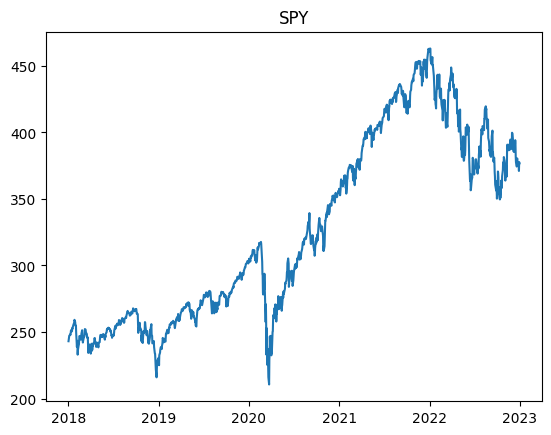

[*********************100%%**********************]  1 of 1 completed


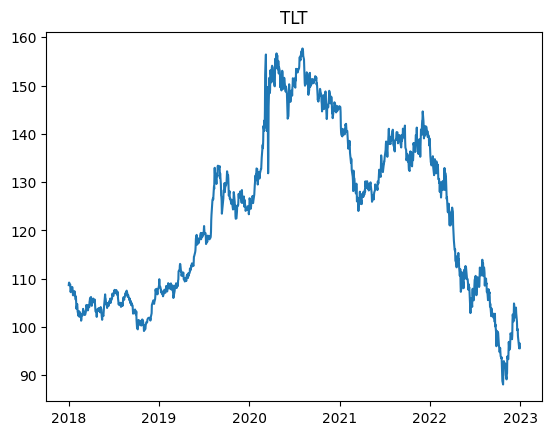

[*********************100%%**********************]  1 of 1 completed


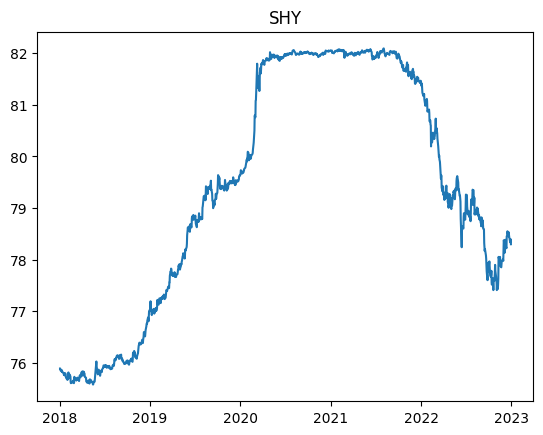

[*********************100%%**********************]  1 of 1 completed


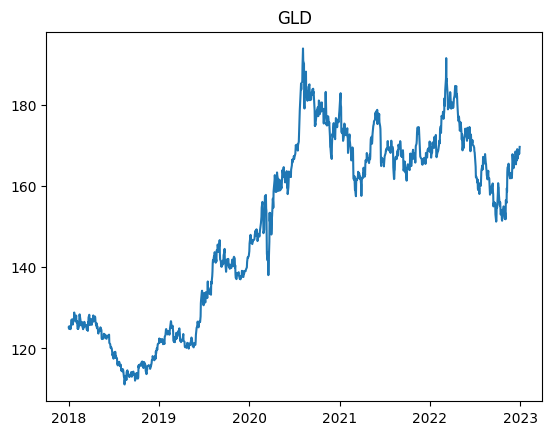

[*********************100%%**********************]  1 of 1 completed


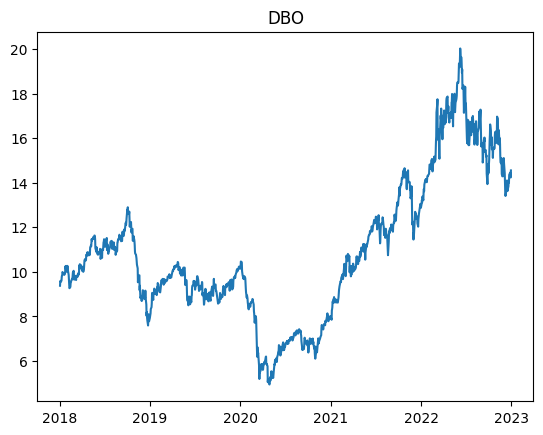

In [234]:
test_df, test_price = download_daily_return_data("2018-01-01", "2022-12-31")

In [160]:
test_df.head()

SPY       TLT       SHY       GLD       DBO
Date                                                        
2018-01-03  0.006325  0.004781  0.000000 -0.002637  0.021590
2018-01-04  0.004215 -0.000158 -0.000478  0.005127  0.001921
2018-01-05  0.006664 -0.002856  0.000000 -0.001036 -0.004794
2018-01-08  0.001828 -0.000636  0.000000 -0.000160  0.005780
2018-01-09  0.002263 -0.013373 -0.000358 -0.004628  0.017241

In [161]:
test_df.shape

(1258, 5)

## Test Data EDA

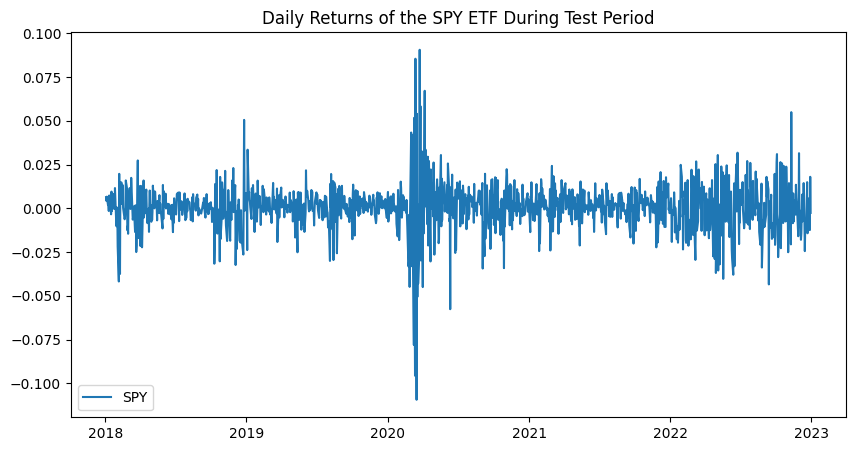

In [163]:
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df.SPY)
plt.title("Daily Returns of the SPY ETF During Test Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

In [164]:
test_df.SPY.describe()

count    1258.000000
mean        0.000441
std         0.013575
min        -0.109424
25%        -0.005130
50%         0.000767
75%         0.007113
max         0.090603
Name: SPY, dtype: float64

Text(0, 0.5, 'Frequency')

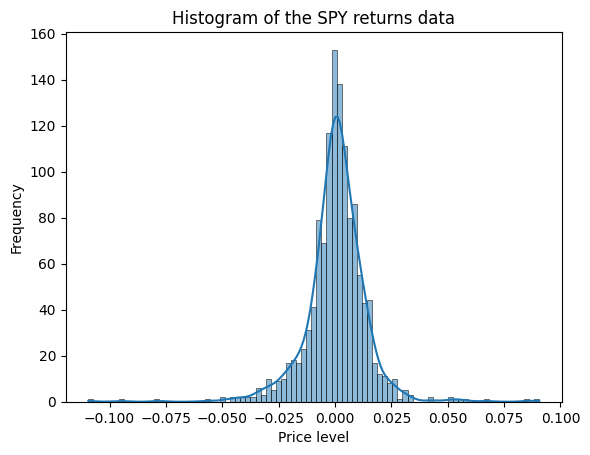

In [165]:
sns.histplot(test_df.SPY, kde=True)
plt.title('Histogram of the SPY returns data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

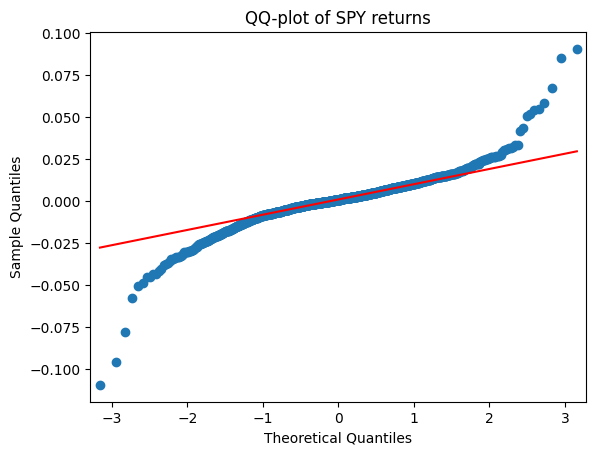

In [166]:
fig = sm.qqplot(test_df.SPY, line='q')
plt.title('QQ-plot of SPY returns')
plt.show()

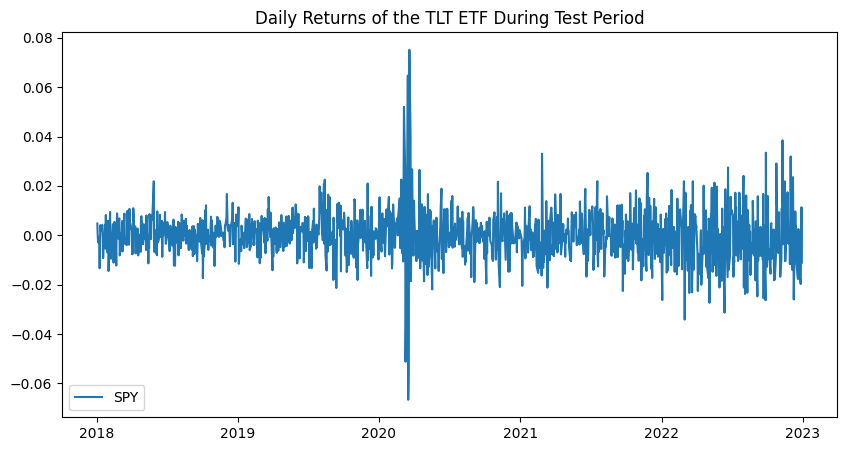

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df.TLT)
plt.title("Daily Returns of the TLT ETF During Test Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

In [168]:
test_df.TLT.describe()

count    1258.000000
mean       -0.000050
std         0.010171
min        -0.066684
25%        -0.005797
50%         0.000072
75%         0.005653
max         0.075195
Name: TLT, dtype: float64

Text(0, 0.5, 'Frequency')

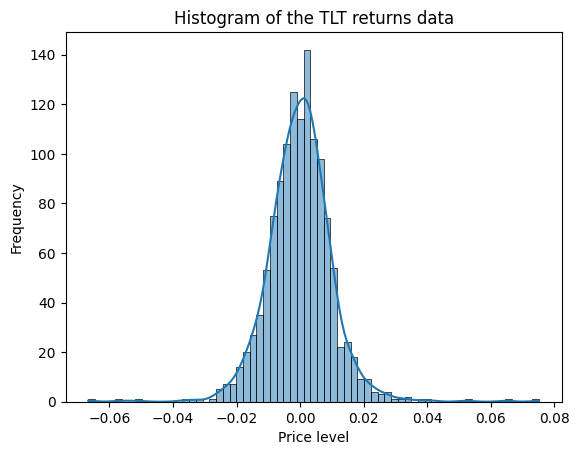

In [169]:
sns.histplot(test_df.TLT, kde=True)
plt.title('Histogram of the TLT returns data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

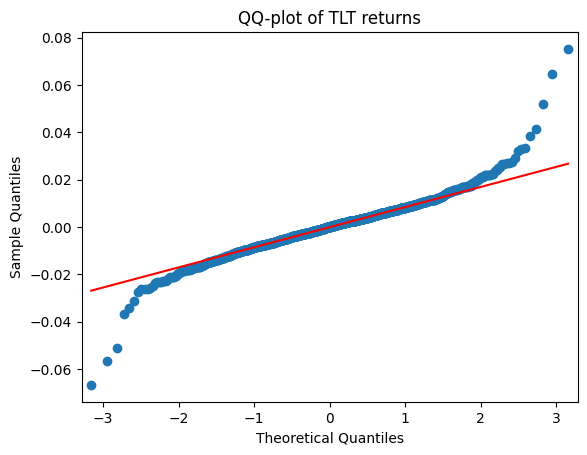

In [170]:
fig = sm.qqplot(test_df.TLT, line='q')
plt.title('QQ-plot of TLT returns')
plt.show()

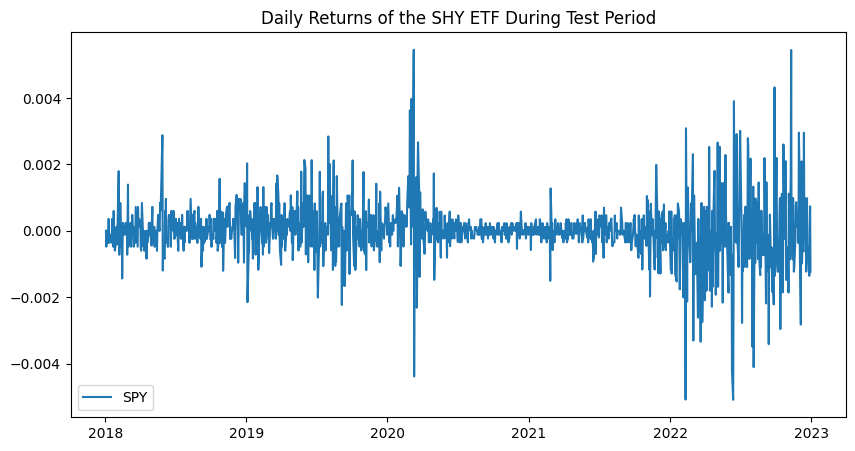

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df.SHY)
plt.title("Daily Returns of the SHY ETF During Test Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

In [172]:
test_df.SHY.describe()

count    1258.000000
mean        0.000025
std         0.000883
min        -0.005088
25%        -0.000348
50%         0.000000
75%         0.000354
max         0.005452
Name: SHY, dtype: float64

Text(0, 0.5, 'Frequency')

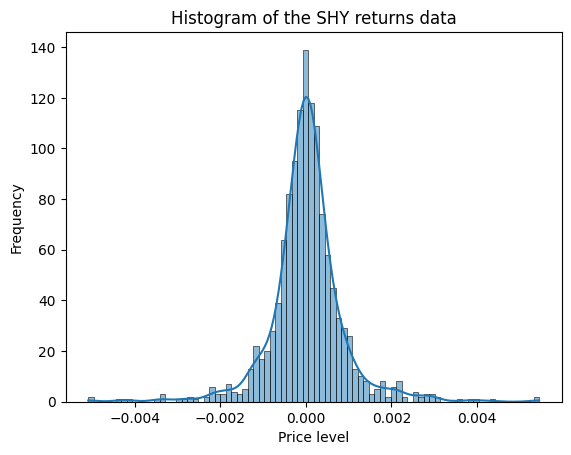

In [173]:
sns.histplot(test_df.SHY, kde=True)
plt.title('Histogram of the SHY returns data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

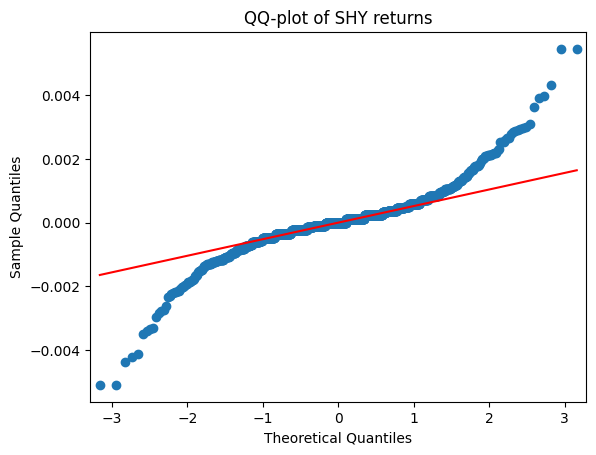

In [174]:
fig = sm.qqplot(test_df.SHY, line='q')
plt.title('QQ-plot of SHY returns')
plt.show()

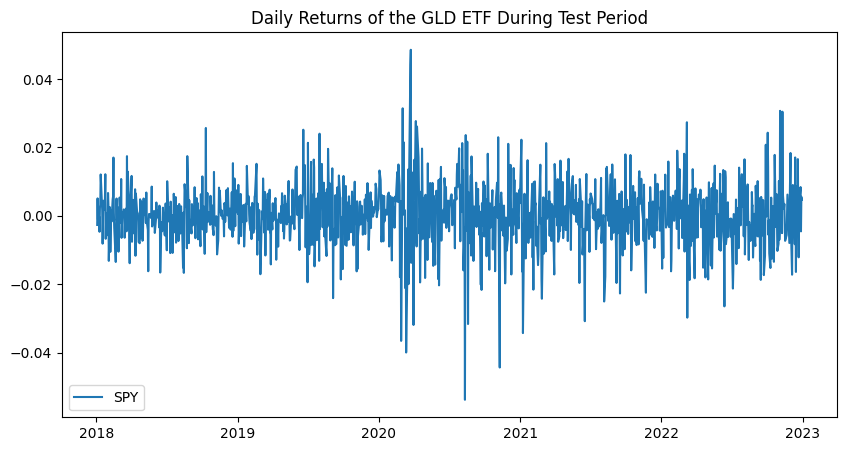

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df.GLD)
plt.title("Daily Returns of the GLD ETF During Test Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

In [176]:
test_df.GLD.describe()

count    1258.000000
mean        0.000283
std         0.009044
min        -0.053694
25%        -0.004325
50%         0.000520
75%         0.005091
max         0.048530
Name: GLD, dtype: float64

Text(0, 0.5, 'Frequency')

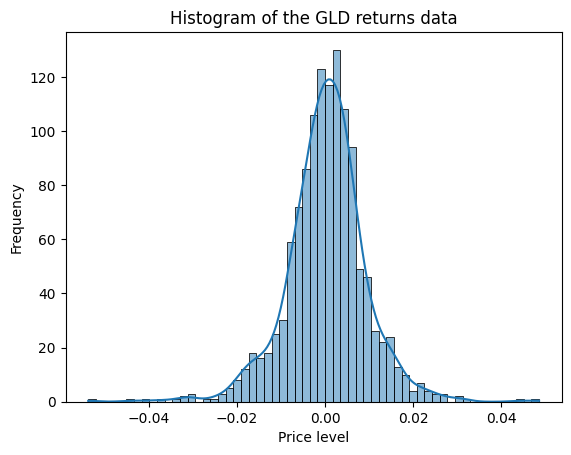

In [177]:
sns.histplot(test_df.GLD, kde=True)
plt.title('Histogram of the GLD returns data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

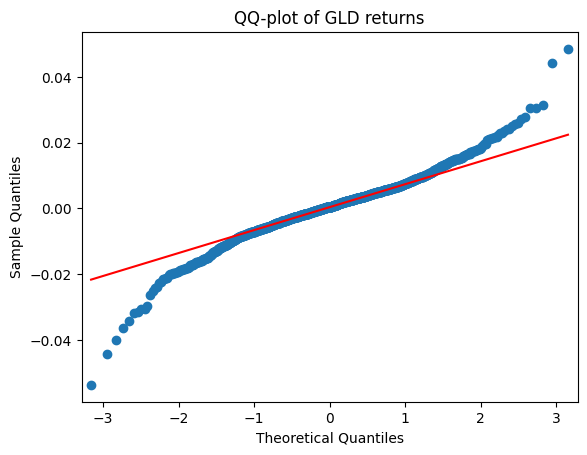

In [178]:
fig = sm.qqplot(test_df.GLD, line='q')
plt.title('QQ-plot of GLD returns')
plt.show()

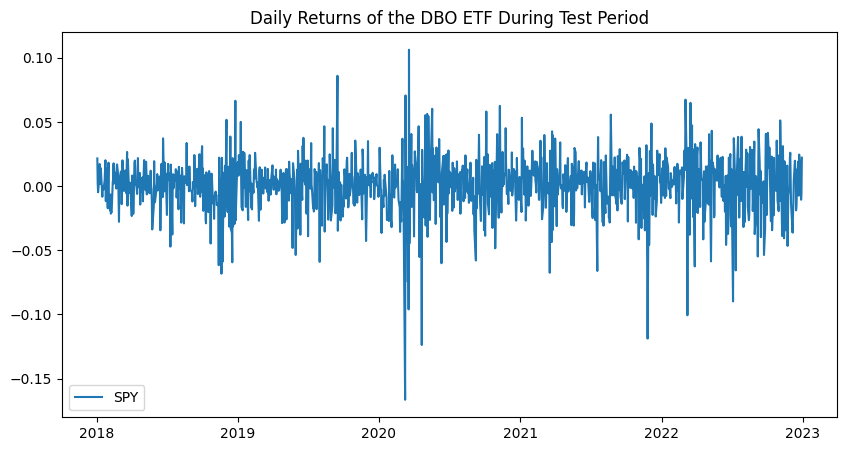

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df.DBO)
plt.title("Daily Returns of the DBO ETF During Test Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

In [180]:
test_df.DBO.describe()

count    1258.000000
mean        0.000587
std         0.021621
min        -0.166453
25%        -0.009601
50%         0.002443
75%         0.012775
max         0.106227
Name: DBO, dtype: float64

Text(0, 0.5, 'Frequency')

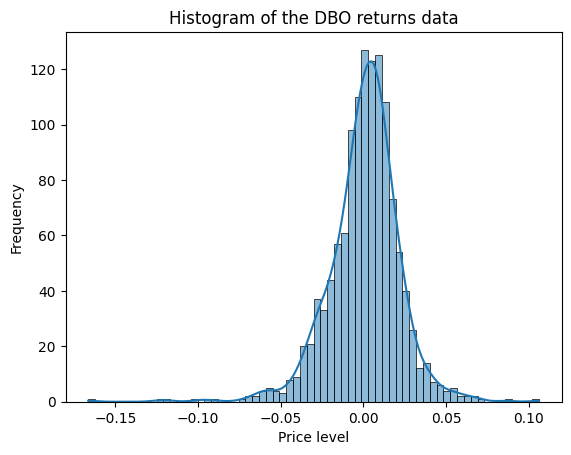

In [181]:
sns.histplot(test_df.DBO, kde=True)
plt.title('Histogram of the DBO returns data')
plt.xlabel('Price level')
plt.ylabel('Frequency')

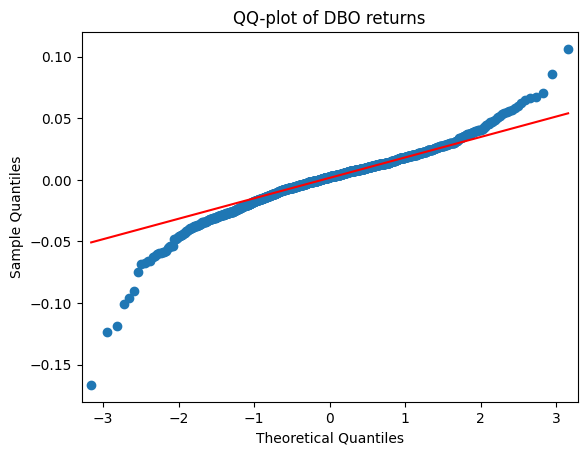

In [182]:
fig = sm.qqplot(test_df.DBO, line='q')
plt.title('QQ-plot of DBO returns')
plt.show()

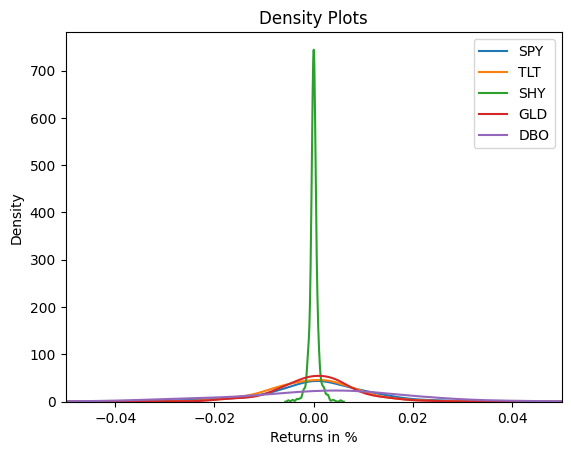

In [183]:
# List tickers = ["SPY", "TLT", "SHY", "GLD", "DBO"]

for column in test_df.columns:
    sns.kdeplot(test_df[column], label=column)

plt.title('Density Plots')
plt.xlabel('Returns in %')
plt.ylabel('Density')
plt.xlim(-0.05, 0.05)
plt.legend()
plt.show()

## Test vs Training Period

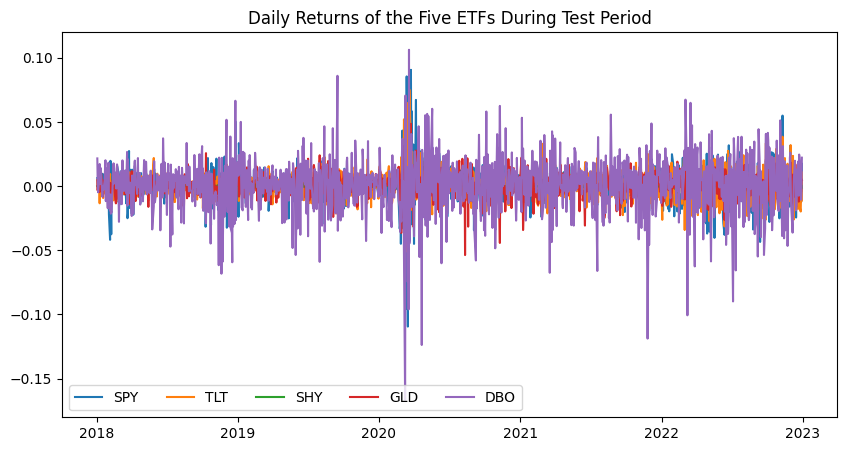

In [162]:
## visualize the dayily returns of the five ETFs over time
plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df)
plt.title("Daily Returns of the Five ETFs During Test Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

From the timeplot during the test period, we can see that:
- All time series of returns seem to be stationary, showing zero-mean reverting.
- The crude oil (DBO) has a coniserable higher volatility than other assets.
- There is a period in the early 2020 that shows extreme volatility, probabbly due to Covid-19.

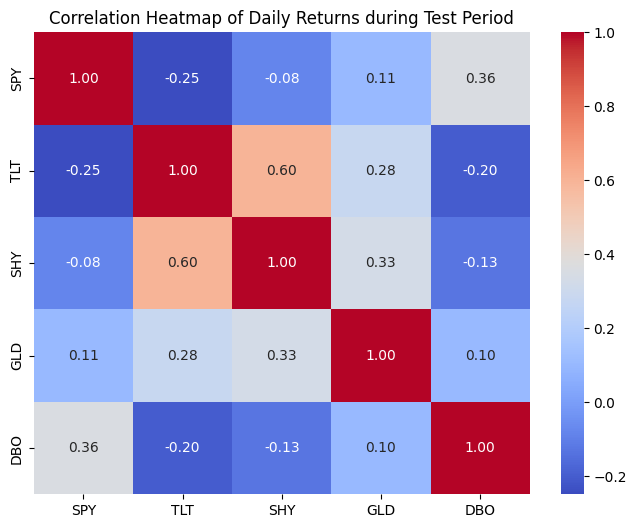

In [184]:
corr = test_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Daily Returns during Test Period")
plt.show()

From the correlation heatmap, we can see:
- The five assets are NOT that correlated.
- The largest correlation is 0.606 betweeen 20+ Year Treasury Bond (TLT) and 1-2 Year Treasury Bond (SHY), which can be expected.
- Treasury Bond is negatively correlated with both S&P500 and Crude Oil.

In [185]:
vix = yf.download('^VIX', start="2000-01-01", end="2022-12-31")
vix_df = vix["Adj Close"]
vix_df.index = pd.to_datetime(vix_df.index, format="%Y%m%d")

[*********************100%%**********************]  1 of 1 completed


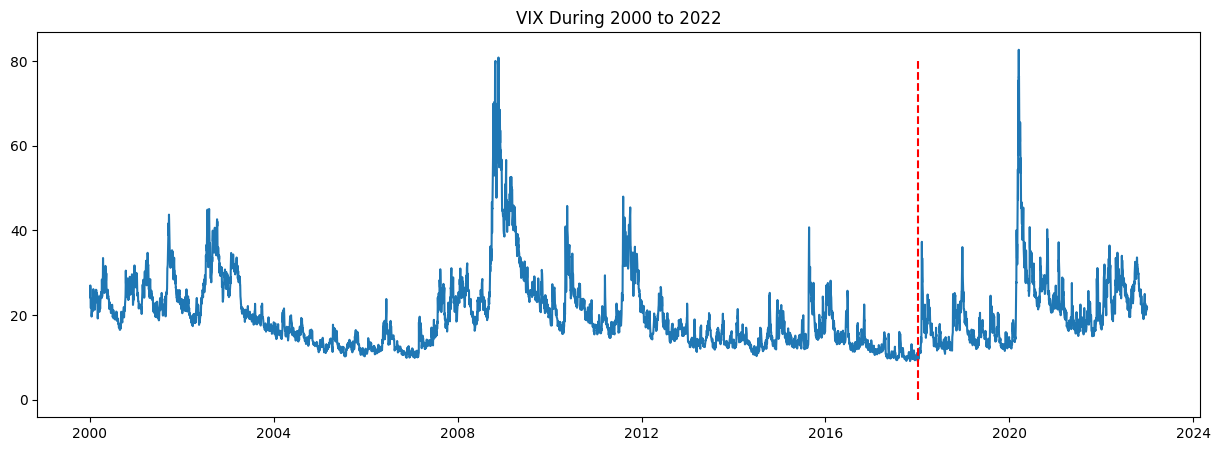

In [186]:
plt.figure(figsize=(15, 5))
plt.plot(vix_df.index, vix_df)
## draw a vertical line at 2008
split = vix_df[vix_df.index.year < 2018].shape[0]
plt.plot([vix_df.index[split + 1], vix_df.index[split + 1]], [0,80], "r--")
plt.title("VIX During 2000 to 2022")
plt.show()

From the timeplot of VIX, we can see the only time that matches the level of high volatility in 2018 is around 2009. For better OOT evaluation of the trained neural networks, we opt to select **the period between 2008 and 2018 as training period**.

[*********************100%%**********************]  1 of 1 completed


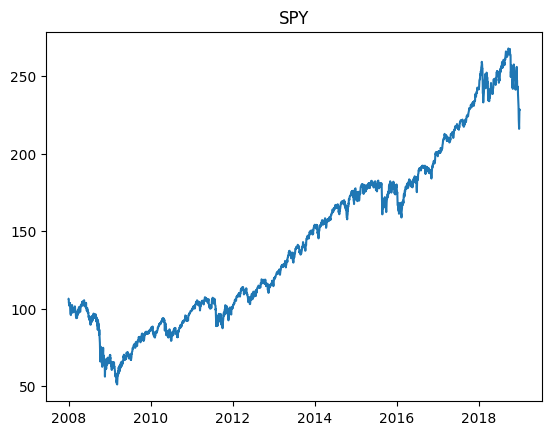

[*********************100%%**********************]  1 of 1 completed


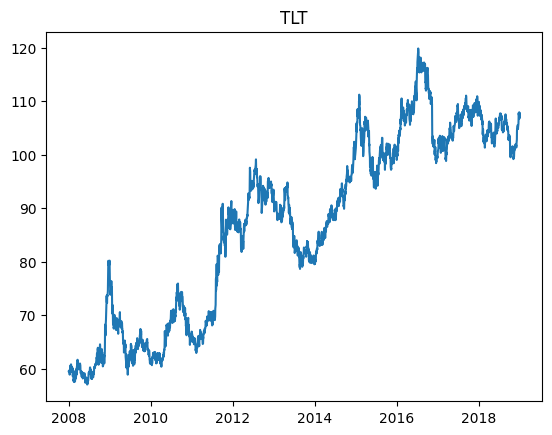

[*********************100%%**********************]  1 of 1 completed


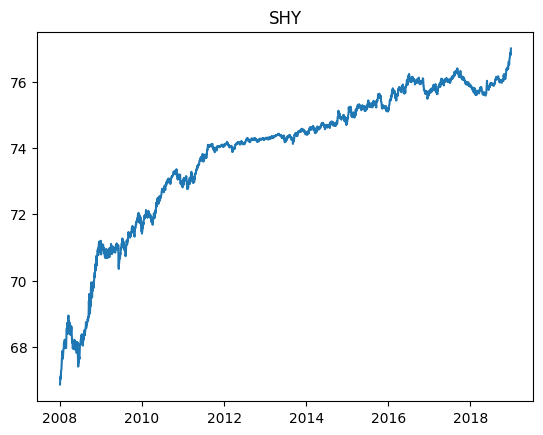

[*********************100%%**********************]  1 of 1 completed


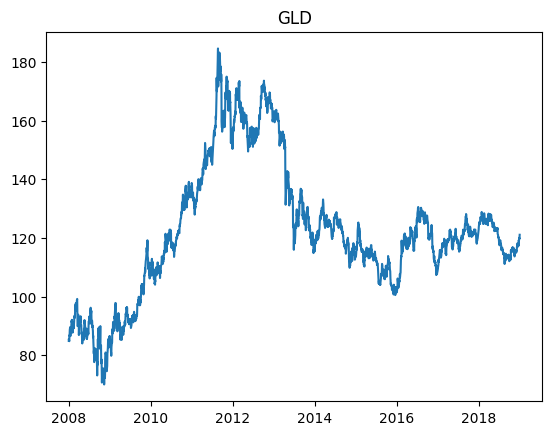

[*********************100%%**********************]  1 of 1 completed


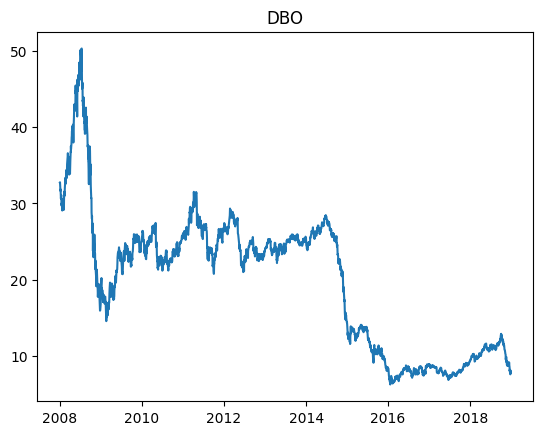

In [235]:
train_df, train_price = download_daily_return_data("2008-01-01", "2018-12-31")

In [188]:
train_df.shape

(2767, 5)

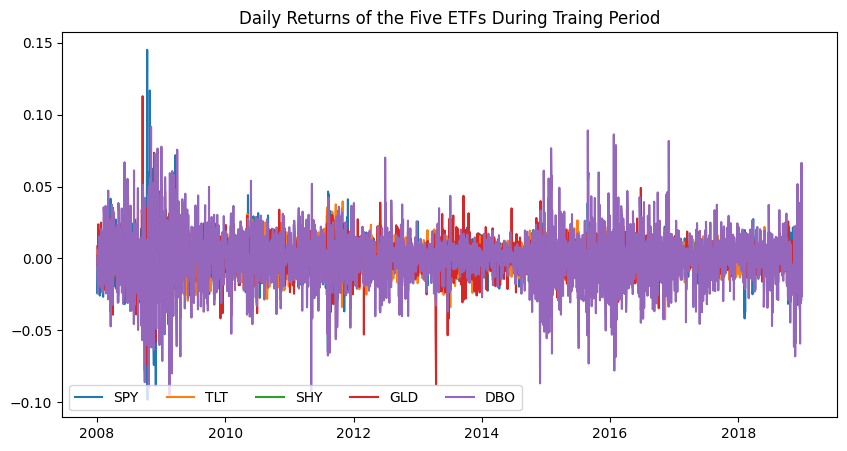

In [189]:
## visualize the dayily returns of the five ETFs over time
plt.figure(figsize=(10, 5))
plt.plot(train_df.index, train_df)
plt.title("Daily Returns of the Five ETFs During Traing Period")
plt.legend(tickers, loc="lower left", ncol=len(tickers))
plt.show()

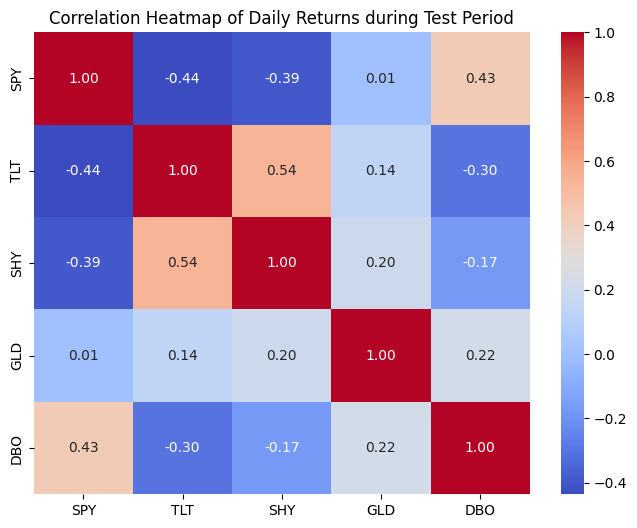

In [190]:
corr = train_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Daily Returns during Test Period")
plt.show()

Those conclusions from visualization during the test period still hold for the training period.

## PCA

In [191]:
## PCA
pca = PCA(n_components=5)
pca.fit(test_df.values)
print(pca.components_.T)
# Cumulative share of the variation of the data predicted the factors
print(np.cumsum(pca.explained_variance_ratio_))

[[-0.31781552 -0.88387045 -0.28021374 -0.19806697  0.00400698]
 [ 0.12743865  0.31715028 -0.7120577  -0.61140986  0.04823801]
 [ 0.00627608  0.01180722 -0.04639316 -0.01732948 -0.99868342]
 [-0.04613728  0.04880346 -0.64143257  0.76404889  0.01682634]
 [-0.93839472  0.34009931  0.02942833 -0.05363243 -0.00231271]]
[0.60893867 0.79456694 0.93213207 0.99943491 1.        ]


From PCA, we can see that the first three principal components are able to explain 93%+ of the variation among the daily returns of the five assets.

Now we've done basic EDA and will move on to modeling.

# Step 2 LSTM for Each ETF

With this data, we will explore using features such as 5-day, 10-day, 25-day and 60-day cumulative returns in addition to 1-day return to predict the 25-day ahead return.




In [192]:
n_features = 1
window_size = 30

In [193]:
def create_dataset(ticker, data_df):
  df = data_df[[ticker]]
  df.columns = ['Ret']
  # df["Ret_5"] = df["Ret"].rolling(5).apply(lambda x: np.prod(1 + x) - 1)
  # df["Ret_10"] = df["Ret"].rolling(10).apply(lambda x: np.prod(1 + x) - 1)
  df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x) - 1)
  # df["Ret_60"] = df["Ret"].rolling(60).apply(lambda x: np.prod(1 + x) - 1)
  df["Ret25"] = df["Ret_25"].shift(-25)
  del df["Ret_25"]
  df = df.dropna()
  Xdf, ydf = df.iloc[:,:-1], df.iloc[:,-1]
  return Xdf.astype("float32"), ydf.astype("float32")

In [194]:
X_train_SPY, y_train_SPY = create_dataset('SPY', train_df)
X_train_TLT, y_train_TLT = create_dataset('TLT', train_df)
X_train_SHY, y_train_SHY = create_dataset('SHY', train_df)
X_train_GLD, y_train_GLD = create_dataset('GLD', train_df)
X_train_DBO, y_train_DBO = create_dataset('DBO', train_df)

In [195]:
X_test_SPY, y_test_SPY = create_dataset('SPY', test_df)
X_test_TLT, y_test_TLT = create_dataset('TLT', test_df)
X_test_SHY, y_test_SHY = create_dataset('SHY', test_df)
X_test_GLD, y_test_GLD = create_dataset('GLD', test_df)
X_test_DBO, y_test_DBO = create_dataset('DBO', test_df)

## Functions

In [425]:
def create_train_test(ticker, window_size, verbose=False, output_scale=True):
  X_train_set = eval("X_train_" + ticker)
  y_train_set = eval("y_train_" + ticker)
  X_test_set = eval("X_test_" + ticker)
  y_test_set = eval("y_test_" + ticker)

  if verbose:
    print("window size: ", window_size)
    print("Shape of dataset", X_train_set.shape, y_train_set.shape, X_test_set.shape, y_test_set.shape)

  scaler_input = MinMaxScaler(feature_range=(-1, 1))
  scaler_input.fit(X_train_set)
  X_train_set_scaled = scaler_input.transform(X_train_set)
  X_test_set_scaled = scaler_input.transform(X_test_set)

  mean_ret = np.mean(y_train_set)

  scaler_output = MinMaxScaler(feature_range=(-1, 1))
  y_train_set = y_train_set.values.reshape(len(y_train_set), -1)
  y_test_set = y_test_set.values.reshape(len(y_test_set), -1)
  if output_scale:
    scaler_output.fit(y_train_set)
    y_train_set_scaled = scaler_output.transform(y_train_set)
  else:
    y_train_set_scaled = y_train_set

  X_train = []
  y_train = []

  for i in range(window_size, y_train_set_scaled.shape[0]):
      X_train.append(X_train_set_scaled[i - window_size : i, :])
      y_train.append(y_train_set_scaled[i])

  X_train, y_train = np.array(X_train), np.array(y_train)

  print("Shape of training data", X_train.shape, y_train.shape)

  X_test = []
  y_test = y_test_set

  for i in range(window_size, y_test_set.shape[0]):
      X_test.append(X_test_set_scaled[i - window_size : i, :])

  X_test, y_test = np.array(X_test), np.array(y_test)
  if verbose:
    print("Shape of test data", X_test.shape, y_test.shape)
  return X_train, y_train, X_test, y_test, scaler_output, mean_ret

In [197]:
def create_LSTM(window_size, n_features, SEED=42):
  K.clear_session()
  tf.random.set_seed(SEED)
  # tf.keras.utils.set_random_seed(SEED)

  units_lstm = 50
  n_dropout = 0.2
  act_fun = "relu"

  model = Sequential()
  model.add(
      LSTM(
          units=units_lstm,
          return_sequences=True,
          activation="tanh",
          input_shape=(window_size, n_features),
      )
  )
  # model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  # model.add(Dropout(n_dropout, seed=SEED))


  # model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  # model.add(Dropout(n_dropout, seed=SEED))


  model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
  # model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(units=20, activation=act_fun))
  # model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(units=10, activation=act_fun))
  # model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(1))
  return model

In [198]:
model = create_LSTM(window_size, n_features)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31841 (124.38 KB)
Trainable params: 31841 (124.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [199]:
def R2_campbell(y_true, y_predicted, mean_ret):
    y_true = y_true.reshape((-1,))
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score

In [200]:
def cal_sign_accuracy(label, predictions):
  label_sign = pd.Series(label.flatten()).apply(np.sign)
  pred_sign = pd.Series(predictions.flatten()).apply(np.sign)
  total = len(label_sign)
  comp = [1 if a==b else 0 for a, b in zip(label_sign, pred_sign)]
  acc = sum(comp) / total
  return acc

## SPY

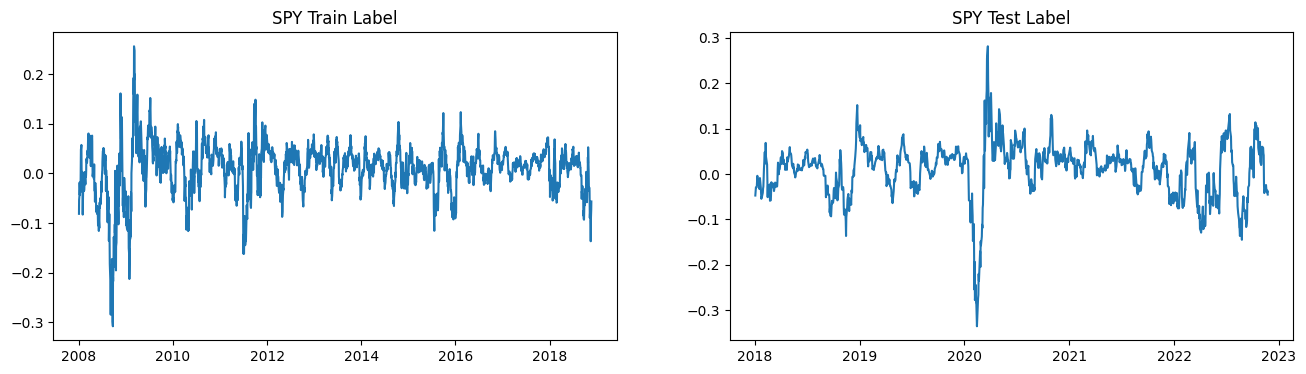

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plot the first subplot
axes[0].plot(y_train_SPY.index, y_train_SPY.values)
axes[0].set_title("SPY Train Label")
# plot the second subplot
axes[1].plot(y_test_SPY.index, y_test_SPY.values)
axes[1].set_title("SPY Test Label")
plt.show()

In [ ]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test('SPY', window_size, verbose=True, output_scale=False)

window size:  30
Shape of dataset (2742, 1) (2742,) (1233, 1) (1233,)
Shape of training data (2712, 30, 1) (2712, 1)
Shape of test data (1203, 30, 1) (1233, 1)


In [ ]:
tse = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train))
print(tse, tse * 0.6)

0.0025597643 0.0015358585864305495


### 100 Epoch

In [ ]:
model = create_LSTM(window_size, n_features)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31841 (124.38 KB)
Trainable params: 31841 (124.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
43/43 

85/85 [==============================] - 1s 9ms/step
0.0016512779 0.3549381586474567 0.709070796460177


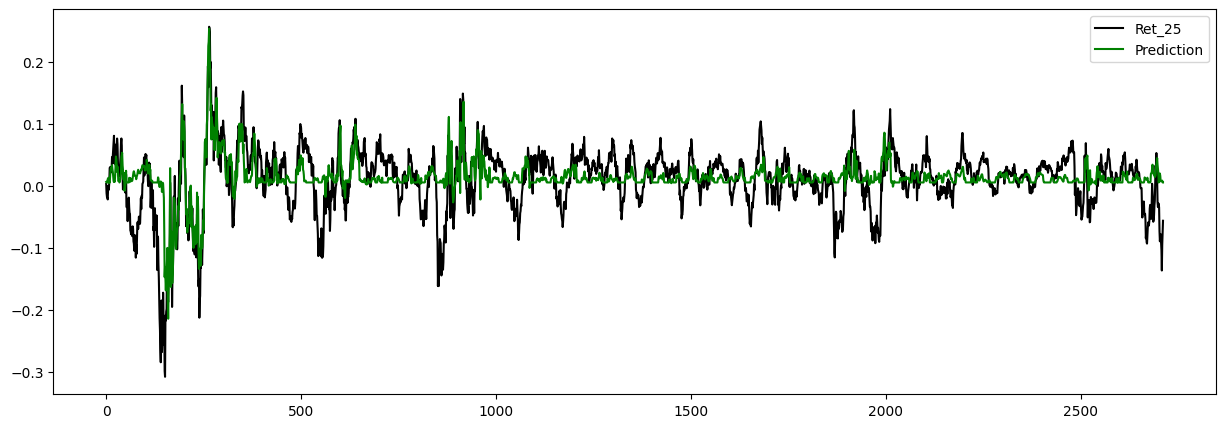

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 0s 9ms/step
0.0056401137 -0.5685035152952205 0.6533665835411472


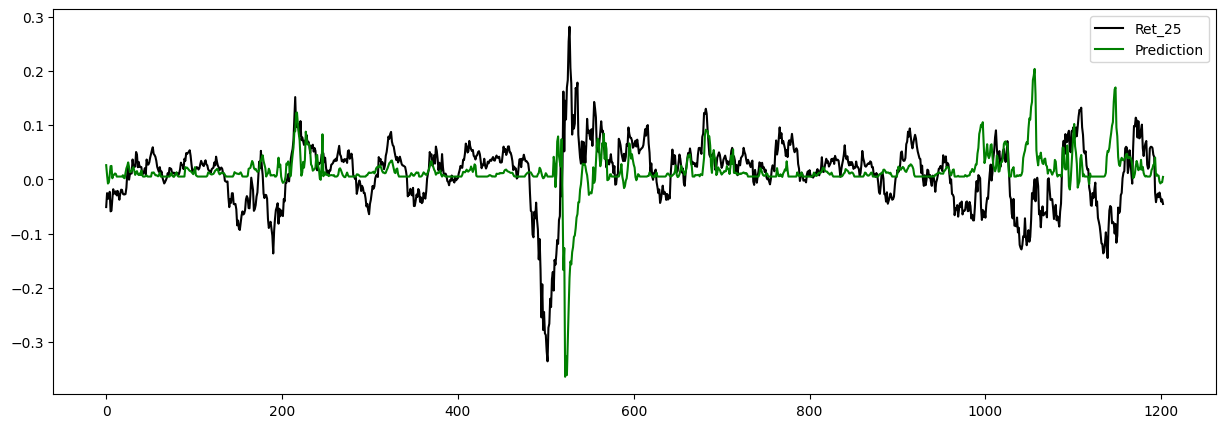

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_SPY_epoch_100_batch_64.h5')

### 60% TSE

After 100 epochs, R2 is still less than 40% yet the model already overfits the training data judging by OOT R2. This part is omitted.

## TLT

Text(0.5, 1.0, 'TLT Test Label')

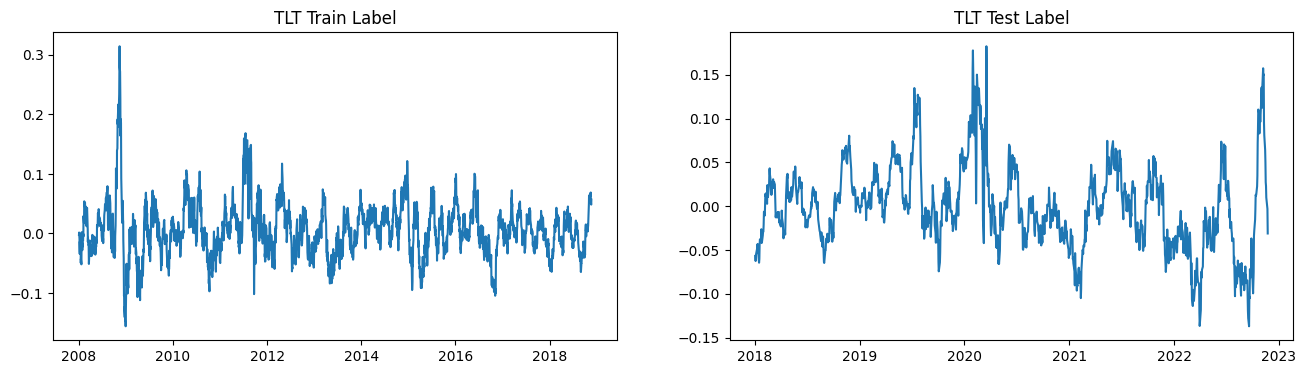

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plot the first subplot
axes[0].plot(y_train_TLT.index, y_train_TLT.values)
axes[0].set_title("TLT Train Label")
# plot the second subplot
axes[1].plot(y_test_TLT.index, y_test_TLT.values)
axes[1].set_title("TLT Test Label")
plt.show()

In [ ]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test('TLT', window_size, verbose=True, output_scale=False)

window size:  30
Shape of dataset (2742, 1) (2742,) (1233, 1) (1233,)
Shape of training data (2712, 30, 1) (2712, 1)
Shape of test data (1203, 30, 1) (1233, 1)


In [ ]:
tse = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train))
print(tse, tse * 0.6)

0.001985607 0.0011913641821593047


### 100 Epoch

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31841 (124.38 KB)
Trainable params: 31841 (124.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
85/85 

85/85 [==============================] - 4s 24ms/step
0.0004858227 0.755331575797831 0.7997787610619469


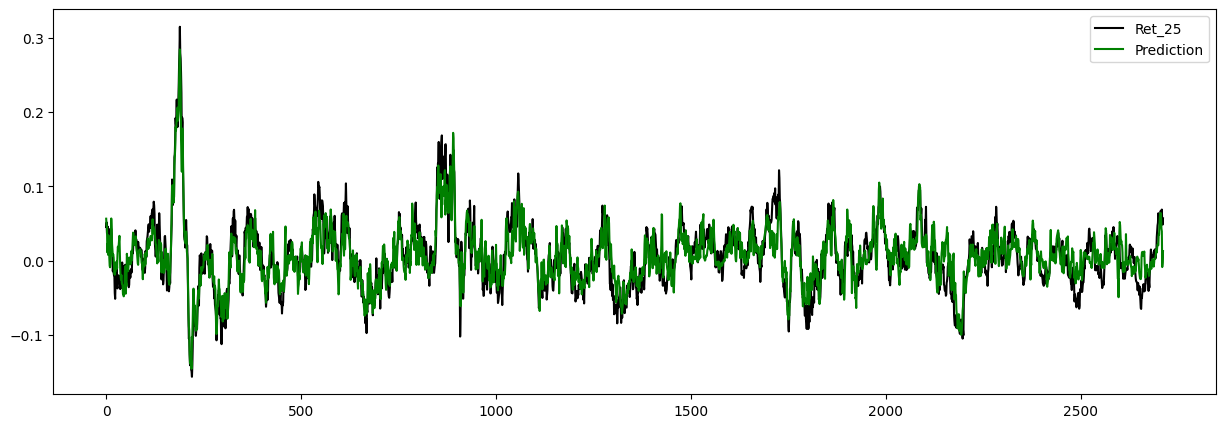

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 1s 15ms/step
0.0029485892 -0.2761944309894251 0.5477971737323358


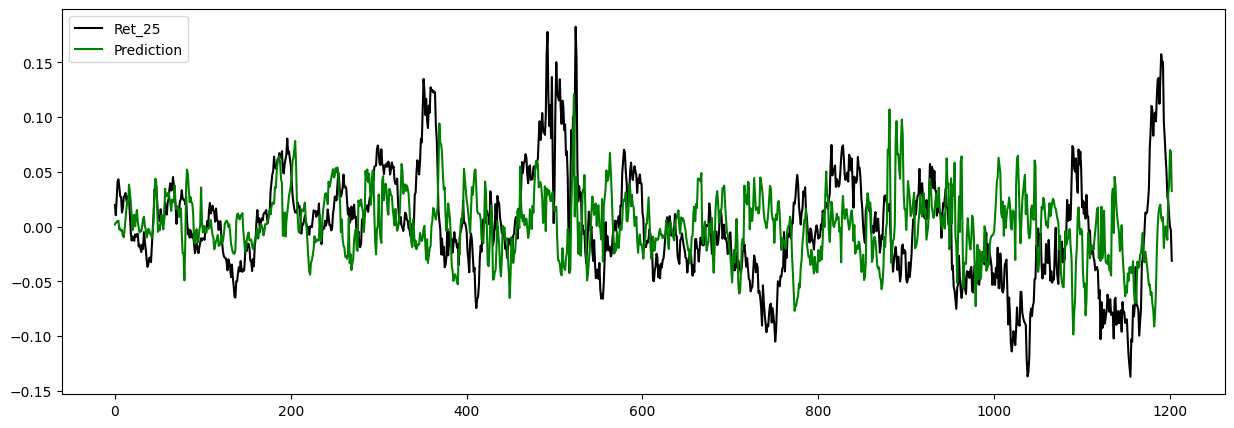

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_TLT_epoch_100.h5')

### 60% TSE

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer='adam',loss='mean_squared_error')
for i in range(10):
  model.fit(X_train,y_train,epochs=10,batch_size=32)
  predictions = model.predict(X_train)
  acc = cal_sign_accuracy(y_train, predictions)
  mse = mean_squared_error(y_train, predictions)
  print("Epoch {0}, Loss: {1}, Sign Agreement: {2}%".format((i+1)*10, mse, acc * 100))
  if mse < tse * 0.6 and i >= 5:
    break

85/85 [==============================] - 1s 9ms/step
0.0010825951 0.4547869873782765 0.6828908554572272


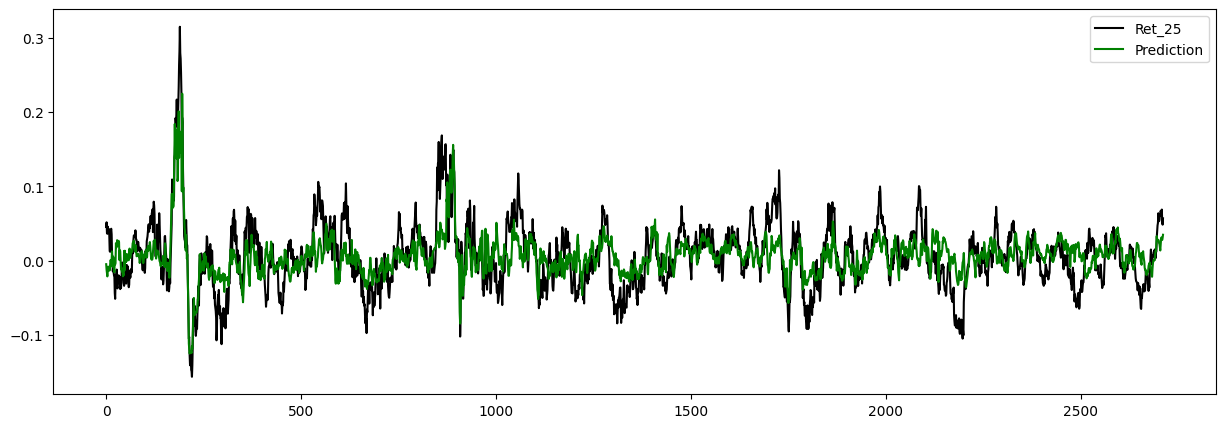

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 0s 8ms/step
0.002378142 -0.0292965104339582 0.5743973399833749


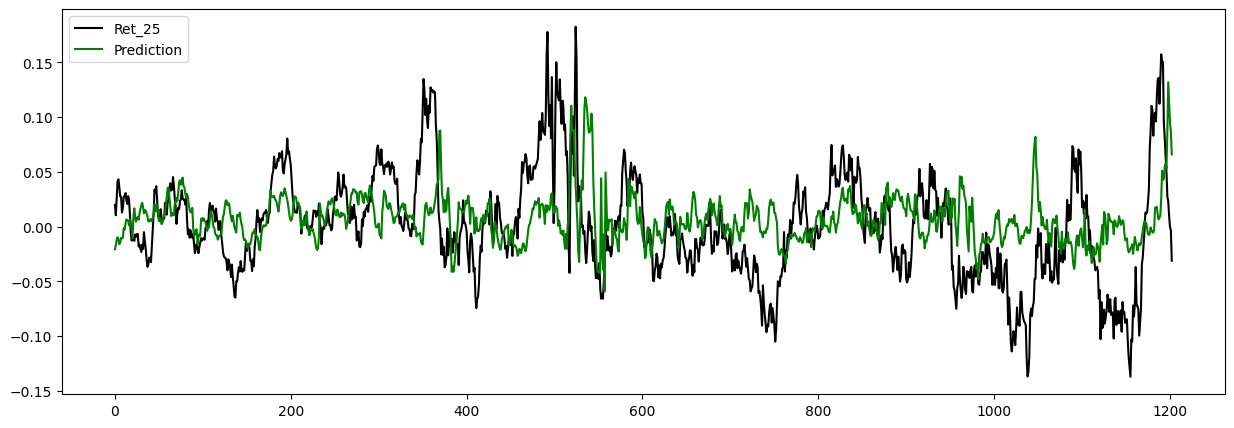

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_TLT_epoch_70.h5')

## SHY

Text(0.5, 1.0, 'SHY Test Label')

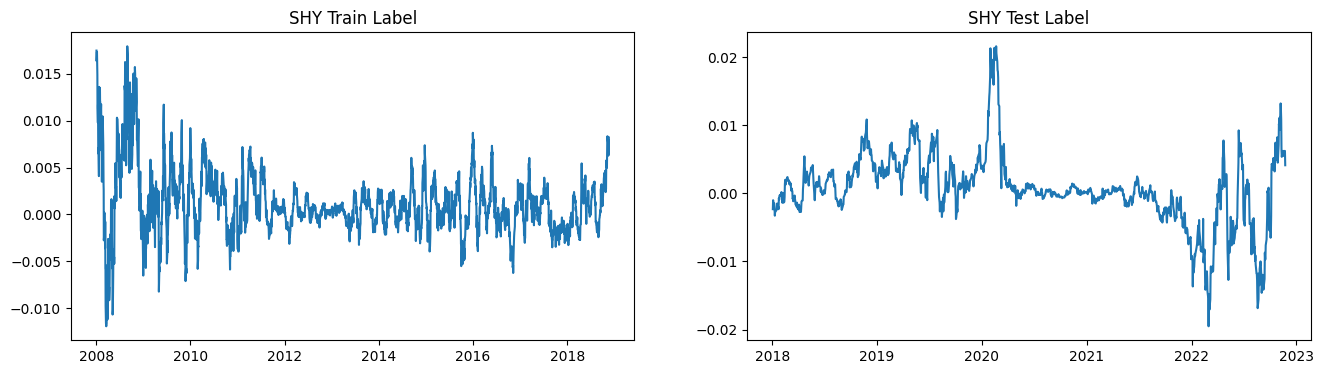

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plot the first subplot
axes[0].plot(y_train_SHY.index, y_train_SHY.values)
axes[0].set_title("SHY Train Label")
# plot the second subplot
axes[1].plot(y_test_SHY.index, y_test_SHY.values)
axes[1].set_title("SHY Test Label")
plt.show()

In [ ]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test('SHY', window_size, verbose=True, output_scale=False)

window size:  30
Shape of dataset (2742, 1) (2742,) (1233, 1) (1233,)
Shape of training data (2712, 30, 1) (2712, 1)
Shape of test data (1203, 30, 1) (1233, 1)


In [ ]:
tse = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train))
print(tse, tse * 0.6)

1.0435773e-05 6.261463931878097e-06


### 100 Epoch

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 9s 24ms/step - loss: 1.1508e-05
Epoch 2/100
85/85 [==============================] - 2s 25ms/step - loss: 1.0046e-05
Epoch 3/100
85/85 [==============================] - 2s 26ms/step - loss: 9.9123e-06
Epoch 4/100
85/85 [==============================] - 3s 37ms/step - loss: 9.8727e-06
Epoch 5/100
85/85 [==============================] - 2s 25ms/step - loss: 9.8606e-06
Epoch 6/100
85/85 [==============================] - 2s 25ms/step - loss: 9.7521e-06
Epoch 7/100
85/85 [==============================] - 2s 24ms/step - loss: 9.7135e-06
Epoch 8/100
85/85 [==============================] - 2s 25ms/step - loss: 9.6236e-06
Epoch 9/100
85/85 [==============================] - 3s 30ms/step - loss: 9.5108e-06
Epoch 10/100
85/85 [==============================] - 3s 32ms/step - loss: 9.5658e-06
Epoch 11/100
85/85 [==============================] - 2s 24ms/step - loss: 9.5871e-06
Epoch 12/100
85/85 [==============================] - 2s 25ms/s

85/85 [==============================] - 2s 8ms/step
7.276468e-06 0.30348711659695304 0.6585545722713865


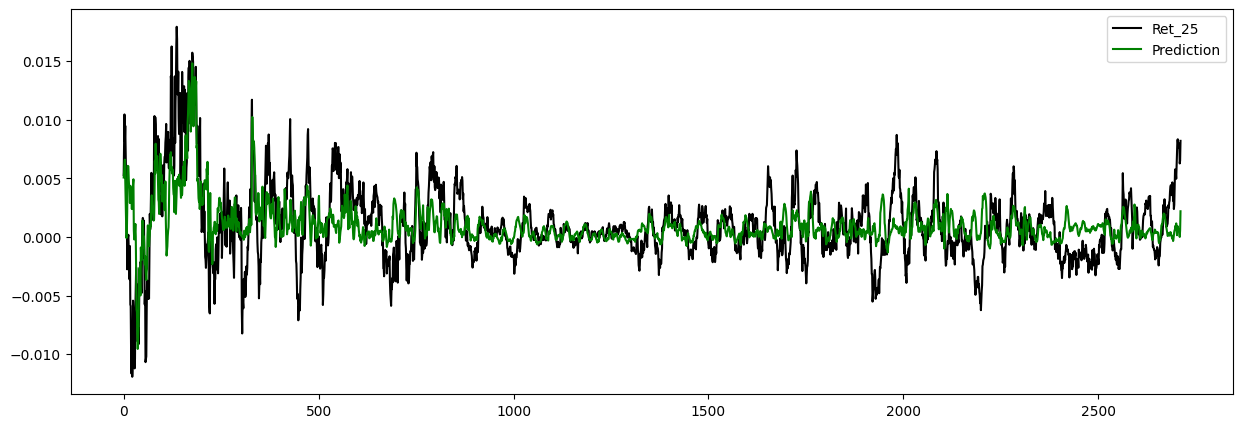

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 1s 14ms/step
3.315971e-05 -0.2063379855129095 0.600997506234414


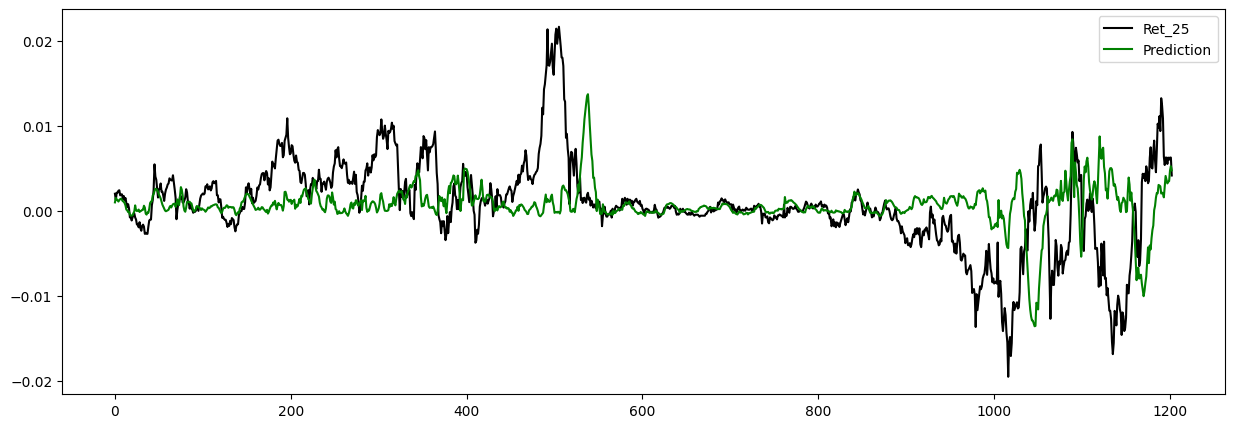

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_SHY_epoch_100_lr_4.h5')

### 60% TSE

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mean_squared_error')

for i in range(15):
  model.fit(X_train,y_train,epochs=10,batch_size=32)
  predictions = model.predict(X_train)
  acc = cal_sign_accuracy(y_train, predictions)
  mse = mean_squared_error(y_train, predictions)
  print("Epoch {0}, Loss: {1}, Sign Agreement: {2}%".format((i+1)*10, mse, acc * 100))
  if mse < tse * 0.6 and i >= 5:
    break

Epoch 1/10
85/85 [==============================] - 8s 25ms/step - loss: 1.0322e-05
Epoch 2/10
85/85 [==============================] - 3s 34ms/step - loss: 9.9012e-06
Epoch 3/10
85/85 [==============================] - 4s 47ms/step - loss: 9.6150e-06
Epoch 4/10
85/85 [==============================] - 3s 41ms/step - loss: 9.6340e-06
Epoch 5/10
85/85 [==============================] - 2s 25ms/step - loss: 9.5615e-06
Epoch 6/10
85/85 [==============================] - 3s 30ms/step - loss: 9.5076e-06
Epoch 7/10
85/85 [==============================] - 3s 32ms/step - loss: 9.4544e-06
Epoch 8/10
85/85 [==============================] - 2s 25ms/step - loss: 9.4176e-06
Epoch 9/10
85/85 [==============================] - 2s 25ms/step - loss: 9.3503e-06
Epoch 10/10
85/85 [==============================] - 2s 10ms/step
Epoch 10, Loss: 9.779850188351702e-06, Sign Agreement: 61.98377581120944%
Epoch 1/10
85/85 [==============================] - 2s 25ms/step - loss: 9.3523e-06
Epoch 2/10
85/85 [==

85/85 [==============================] - 1s 8ms/step
6.468163e-06 0.38085909461474377 0.6585545722713865


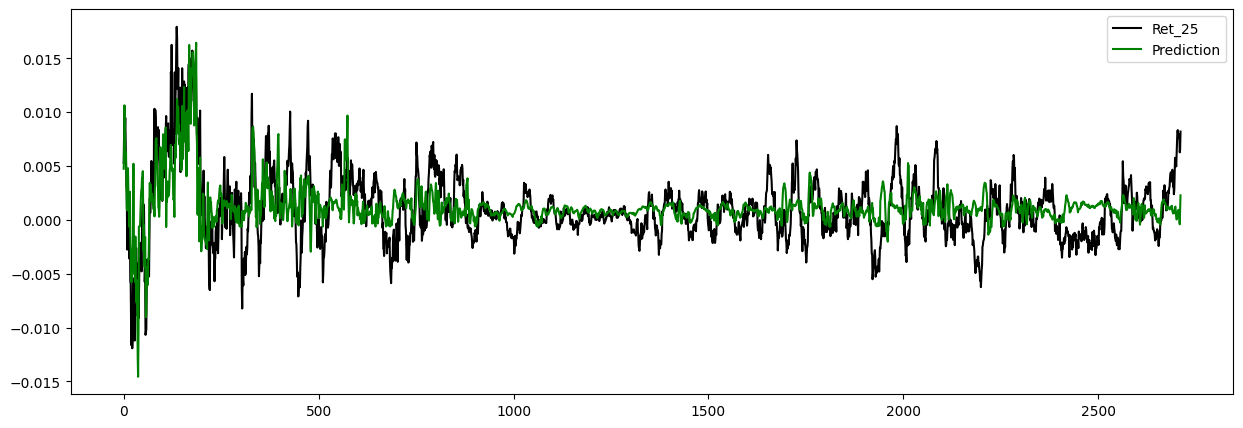

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 0s 9ms/step
4.5572244e-05 -0.6579012717788197 0.5976724854530341


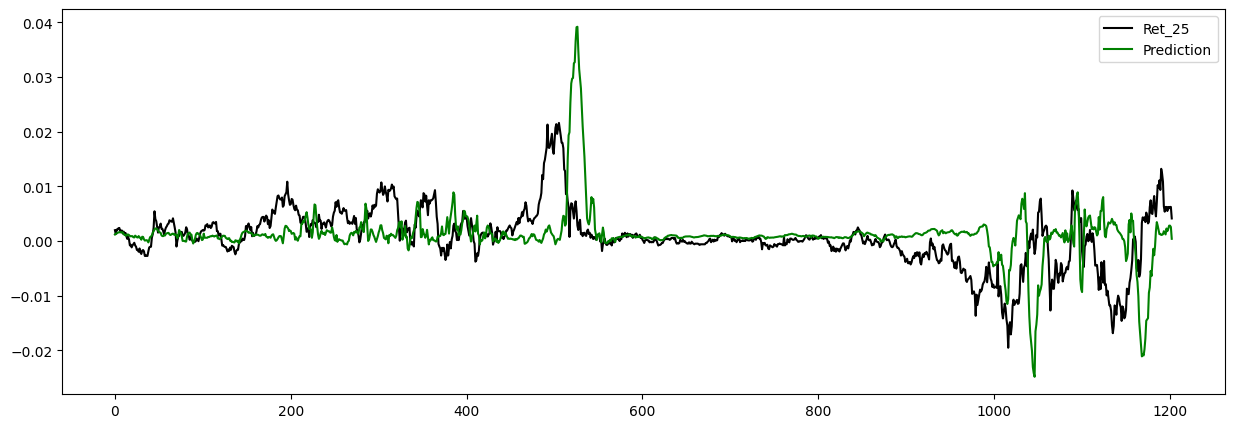

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_SHY_epoch_150_lr_4.h5')

## GLD

Text(0.5, 1.0, 'GLD Test Label')

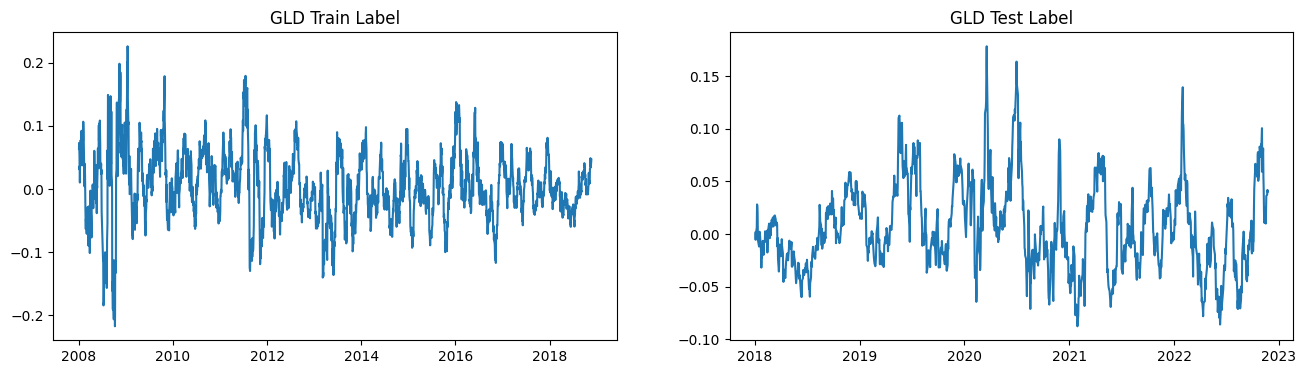

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plot the first subplot
axes[0].plot(y_train_GLD.index, y_train_GLD.values)
axes[0].set_title("GLD Train Label")
# plot the second subplot
axes[1].plot(y_test_GLD.index, y_test_GLD.values)
axes[1].set_title("GLD Test Label")
plt.show()

In [ ]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test('GLD', window_size, verbose=True, output_scale=False)

window size:  30
Shape of dataset (2742, 1) (2742,) (1233, 1) (1233,)
Shape of training data (2712, 30, 1) (2712, 1)
Shape of test data (1203, 30, 1) (1233, 1)


In [ ]:
tse = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train))
print(tse, tse * 0.6)

0.002908078 0.0017448468133807182


### 100 Epoch

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 7s 37ms/step - loss: 0.0029
Epoch 2/100
85/85 [==============================] - 2s 24ms/step - loss: 0.0029
Epoch 3/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 4/100
85/85 [==============================] - 4s 44ms/step - loss: 0.0029
Epoch 5/100
85/85 [==============================] - 6s 69ms/step - loss: 0.0029
Epoch 6/100
85/85 [==============================] - 3s 35ms/step - loss: 0.0029
Epoch 7/100
85/85 [==============================] - 4s 50ms/step - loss: 0.0029
Epoch 8/100
85/85 [==============================] - 4s 48ms/step - loss: 0.0028
Epoch 9/100
85/85 [==============================] - 3s 41ms/step - loss: 0.0029
Epoch 10/100
85/85 [==============================] - 3s 38ms/step - loss: 0.0029
Epoch 11/100
85/85 [==============================] - 4s 51ms/step - loss: 0.0029
Epoch 12/100
85/85 [==============================] - 4s 51ms/step - loss: 0.0029
Epoch 13/100
85/85 [=====

85/85 [==============================] - 2s 8ms/step
0.0015228156 0.4764190155254421 0.6969026548672567


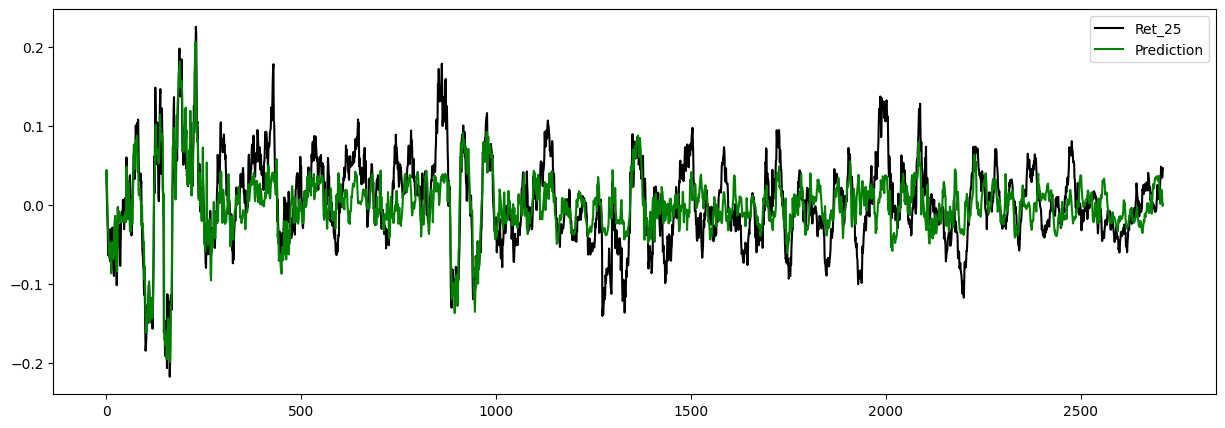

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 0s 8ms/step
0.00196783 -0.1403861717331647 0.5843724023275145


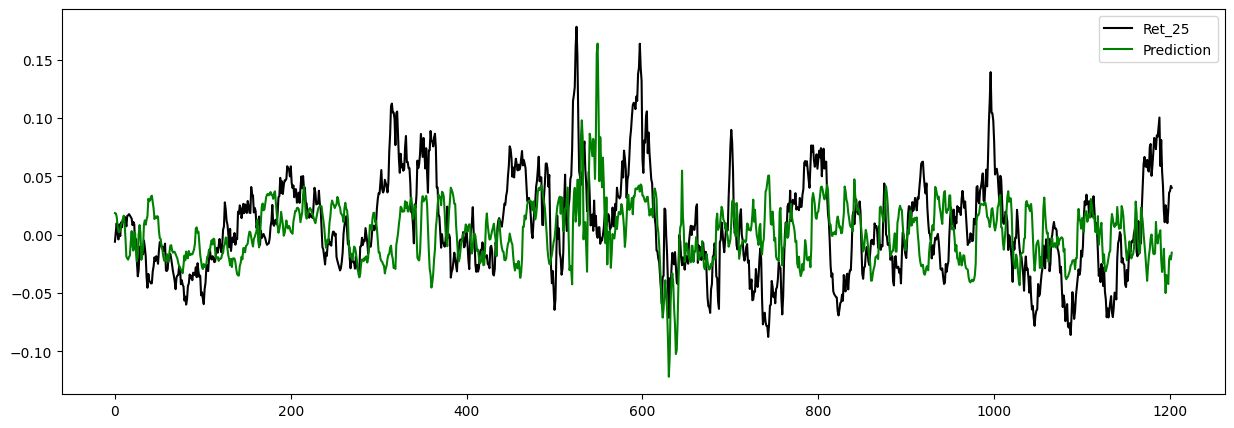

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
model.save('model_GLD_epoch_100.h5')

### 60% TSE

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer='adam',loss='mean_squared_error')
for i in range(10):
  model.fit(X_train,y_train,epochs=10,batch_size=32)
  predictions = model.predict(X_train)
  acc = cal_sign_accuracy(y_train, predictions)
  mse = mean_squared_error(y_train, predictions)
  print("Epoch {0}, Loss: {1}, Sign Agreement: {2}%".format((i+1)*10, mse, acc * 100))
  if mse < tse * 0.6 and i >= 5:
    break

Epoch 1/10
85/85 [==============================] - 8s 31ms/step - loss: 0.0029
Epoch 2/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 3/10
85/85 [==============================] - 2s 24ms/step - loss: 0.0029
Epoch 4/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 5/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 6/10
85/85 [==============================] - 3s 36ms/step - loss: 0.0029
Epoch 7/10
85/85 [==============================] - 3s 32ms/step - loss: 0.0029
Epoch 8/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 9/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 10/10
85/85 [==============================] - 1s 8ms/step
Epoch 10, Loss: 0.0028740516863763332, Sign Agreement: 50.8480825958702%
Epoch 1/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 2/10
85/85 [==============================] - 2s 25ms/st

85/85 [==============================] - 1s 9ms/step
0.0019364195 0.33421193087910794 0.6216814159292036


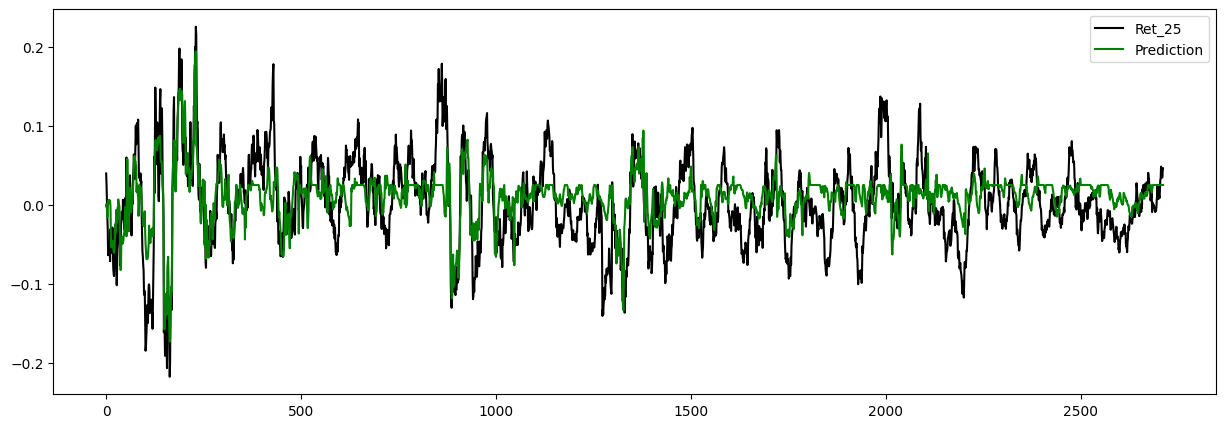

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 1s 13ms/step
0.0018808633 -0.08998773308467145 0.5685785536159601


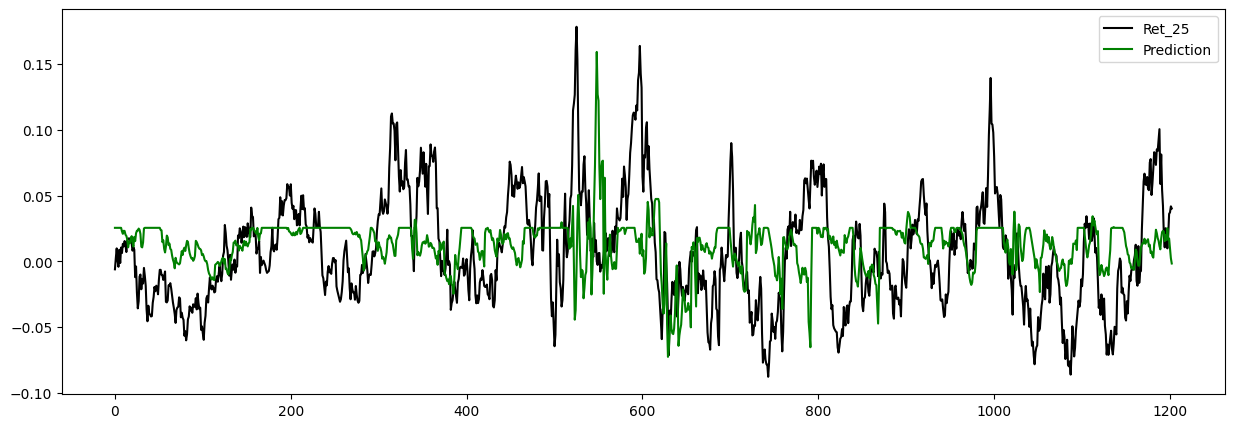

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_GLD_epoch_80.h5')

## DBO

Text(0.5, 1.0, 'DBO Test Label')

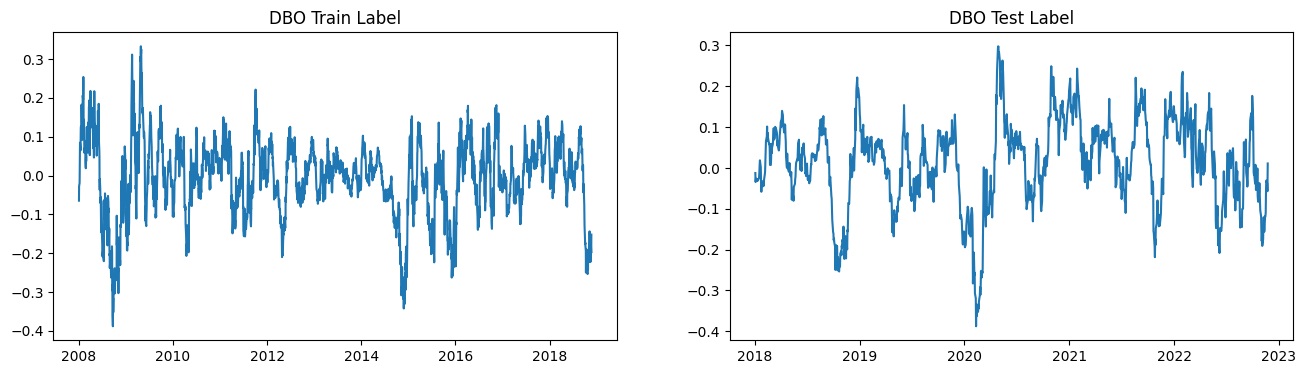

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
# plot the first subplot
axes[0].plot(y_train_DBO.index, y_train_DBO.values)
axes[0].set_title("DBO Train Label")
# plot the second subplot
axes[1].plot(y_test_DBO.index, y_test_DBO.values)
axes[1].set_title("DBO Test Label")

In [ ]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test("DBO", window_size, verbose=True, output_scale=False)

window size:  30
Shape of dataset (2742, 1) (2742,) (1233, 1) (1233,)
Shape of training data (2712, 30, 1) (2712, 1)
Shape of test data (1203, 30, 1) (1233, 1)


In [ ]:
tse = mean_squared_error(y_train, [np.mean(y_train)] * len(y_train))
print(tse, tse * 0.6)

0.009442476 0.005665485374629497


### 100 Epoch

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 7s 38ms/step - loss: 0.0092
Epoch 2/100
85/85 [==============================] - 5s 61ms/step - loss: 0.0089
Epoch 3/100
85/85 [==============================] - 4s 45ms/step - loss: 0.0089
Epoch 4/100
85/85 [==============================] - 2s 28ms/step - loss: 0.0088
Epoch 5/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0088
Epoch 6/100
85/85 [==============================] - 3s 31ms/step - loss: 0.0086
Epoch 7/100
85/85 [==============================] - 3s 30ms/step - loss: 0.0090
Epoch 8/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0087
Epoch 9/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0088
Epoch 10/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0087
Epoch 11/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0088
Epoch 12/100
85/85 [==============================] - 3s 36ms/step - loss: 0.0086
Epoch 13/100
85/85 [=====

85/85 [==============================] - 2s 9ms/step
0.0005697047 0.9396762746620752 0.9174041297935103


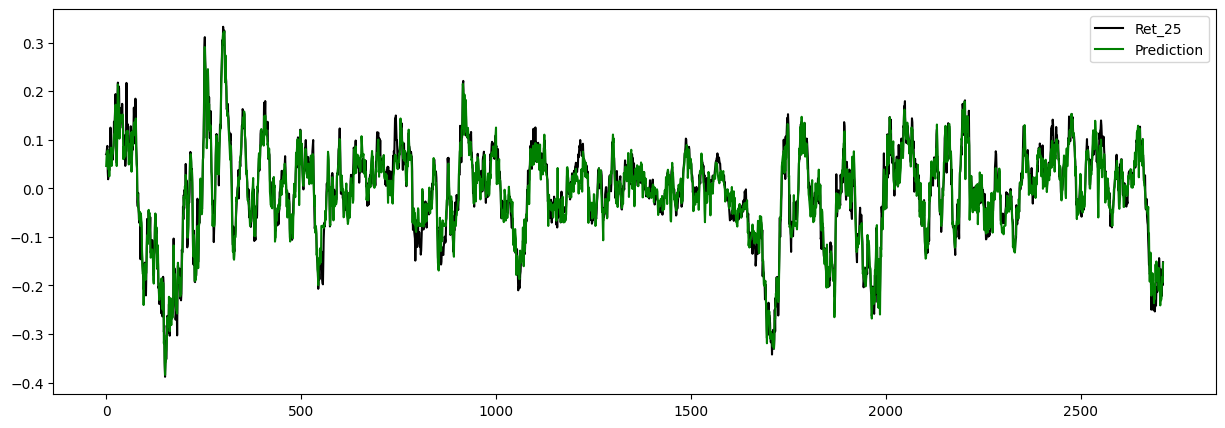

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 0s 9ms/step
0.016036138 -0.35699387147326767 0.542809642560266


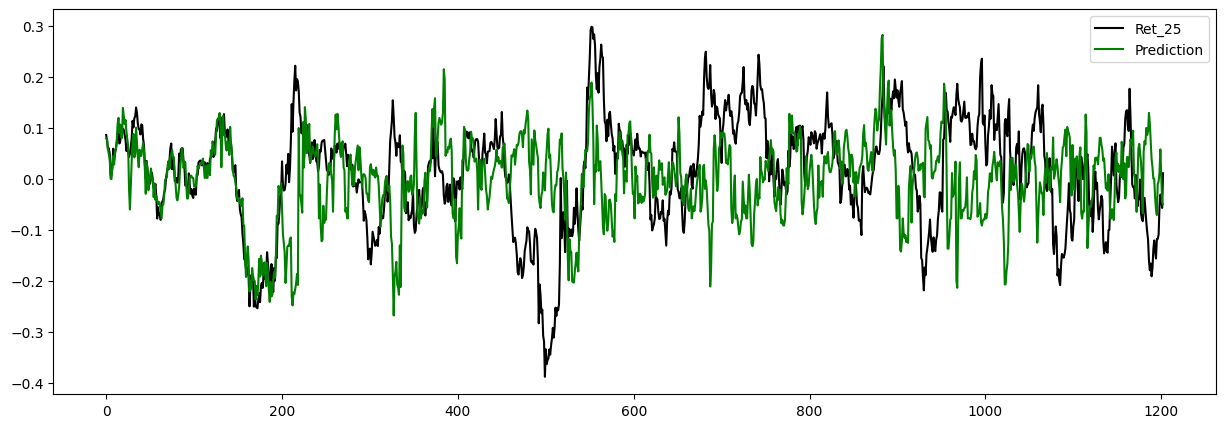

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_DBO_epoch_100.h5')

### 60% TSE

In [ ]:
model = create_LSTM(window_size, n_features)
model.compile(optimizer='adam',loss='mean_squared_error')
for i in range(10):
  model.fit(X_train,y_train,epochs=10,batch_size=32)
  predictions = model.predict(X_train)
  acc = cal_sign_accuracy(y_train, predictions)
  mse = mean_squared_error(y_train, predictions)
  print("Epoch {0}, Loss: {1}, Sign Agreement: {2}%".format((i+1)*10, mse, acc * 100))
  if mse < tse * 0.6 and i >= 5:
    break

Epoch 1/10
85/85 [==============================] - 8s 26ms/step - loss: 0.0090
Epoch 2/10
85/85 [==============================] - 4s 52ms/step - loss: 0.0088
Epoch 3/10
85/85 [==============================] - 5s 54ms/step - loss: 0.0088
Epoch 4/10
85/85 [==============================] - 5s 58ms/step - loss: 0.0087
Epoch 5/10
85/85 [==============================] - 4s 46ms/step - loss: 0.0087
Epoch 6/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0086
Epoch 7/10
85/85 [==============================] - 3s 33ms/step - loss: 0.0087
Epoch 8/10
85/85 [==============================] - 2s 28ms/step - loss: 0.0086
Epoch 9/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0086
Epoch 10/10
85/85 [==============================] - 2s 9ms/step
Epoch 10, Loss: 0.008425910957157612, Sign Agreement: 56.63716814159292%
Epoch 1/10
85/85 [==============================] - 2s 25ms/step - loss: 0.0086
Epoch 2/10
85/85 [==============================] - 2s 25ms/st

85/85 [==============================] - 1s 9ms/step
0.0040991814 0.5659543153805131 0.713495575221239


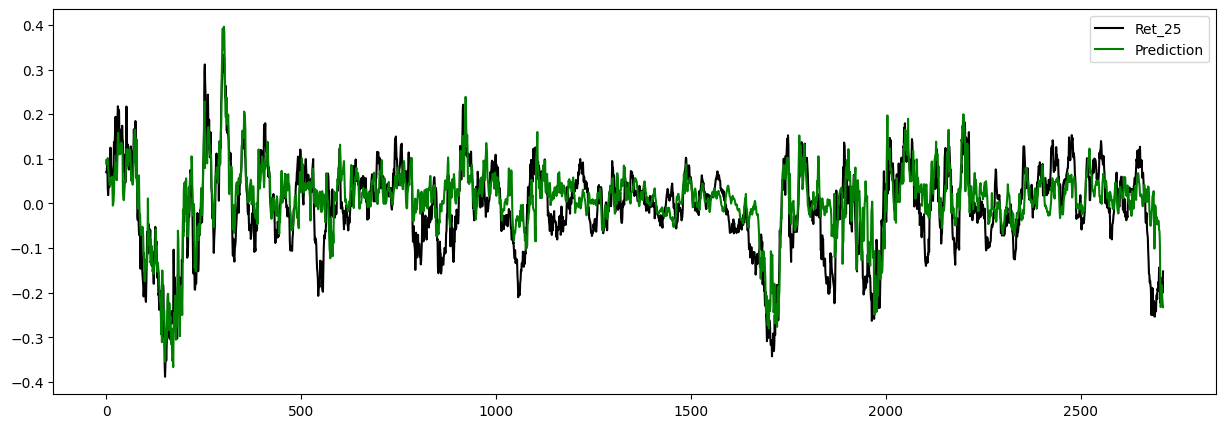

In [ ]:
predictions = model.predict(X_train)
label = y_train
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

38/38 [==============================] - 0s 9ms/step
0.012091787 -0.02321897177108334 0.6242726517040732


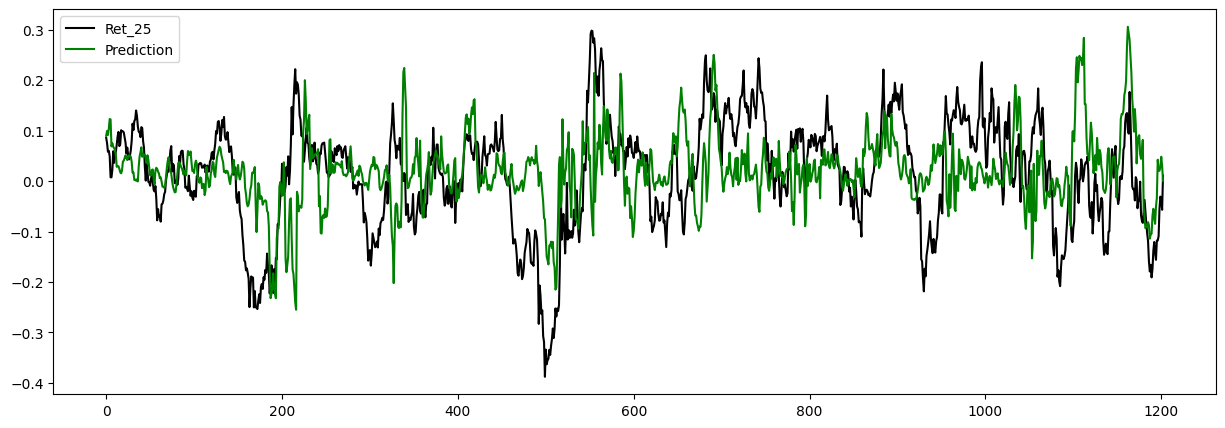

In [ ]:
predictions = model.predict(X_test)
label = y_test[window_size:]
mse = mean_squared_error(label, predictions)
r2 = R2_campbell(label, predictions, mean_ret)
acc = cal_sign_accuracy(label, predictions)
print(mse, r2, acc)
plt.figure(figsize=(15, 5))
plt.plot(label, color = 'black', label = 'Ret_25')
plt.plot(predictions, color = 'green', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# model.save('model_DBO_epoch_80.h5')

## Trading Strategy

### Predictions

For this section, we should work with X_train_{ticker}, y_train_{ticker}, X_test_{ticker}, y_test_{ticker}, and loading the corresponding trained models from disk.

In [480]:
model_SPY = load_model('model_SPY_epoch_100_batch_64.h5')
model_TLT = load_model('model_TLT_epoch_70.h5')
model_SHY = load_model('model_SHY_epoch_100_lr_4.h5')
model_GLD = load_model('model_GLD_epoch_80.h5')
model_DBO = load_model('model_DBO_epoch_60.h5')

In [481]:
window_size = 30
predictions_dic = {}
for ticker in tickers:
  X_train, y_train, X_test, y_test, _, _ = create_train_test(ticker, window_size, output_scale=False)
  model = eval("model_" + ticker)
  predictions = model.predict(X_test).flatten()
  predictions_dic[ticker] = predictions

Shape of training data (2712, 30, 1) (2712, 1)
38/38 [==============================] - 1s 9ms/step
Shape of training data (2712, 30, 1) (2712, 1)
38/38 [==============================] - 1s 8ms/step
Shape of training data (2712, 30, 1) (2712, 1)
38/38 [==============================] - 1s 8ms/step
Shape of training data (2712, 30, 1) (2712, 1)
38/38 [==============================] - 1s 8ms/step
Shape of training data (2712, 30, 1) (2712, 1)
38/38 [==============================] - 1s 9ms/step


In [482]:
predictions_df = pd.DataFrame(predictions_dic)
predictions_df['Date'] = X_test_SPY[window_size:].index
predictions_df.set_index(keys=['Date'], inplace=True)
predictions_df.head()

SPY       TLT       SHY       GLD       DBO
Date                                                        
2018-02-15  0.026252 -0.020606  0.000723  0.037172  0.089906
2018-02-16  0.007950 -0.017009  0.001281  0.049243  0.099414
2018-02-20 -0.007659 -0.011698  0.001643  0.033491  0.091311
2018-02-21 -0.005573 -0.009653  0.001850  0.037750  0.104246
2018-02-22  0.007933 -0.011608  0.001862  0.028495  0.122914

In [356]:
start_dt = predictions_df.index[0]
print(start_dt)

2018-02-15 00:00:00


The baseline is the buy-and-hold strategy on the weighted average of the five ETFs.

In [365]:
test_df_cum = pd.DataFrame()
test_df_cum['Date'] = test_df.index
test_df_cum.set_index(keys=['Date'], inplace=True)
test_df_cum = test_df_cum[test_df_cum.index >= start_dt]

test_df_backtest = test_df[test_df.index >= start_dt]

for ticker in tickers:
  test_df_cum[ticker] = test_df_backtest[ticker].expanding().apply(lambda x: np.prod(1 + x) - 1)

test_df_cum.head()

SPY       TLT      SHY       GLD       DBO
Date                                                       
2018-02-15  0.012760  0.003400 -0.00036  0.001170  0.001936
2018-02-16  0.013057  0.008838 -0.00012 -0.002106  0.008713
2018-02-20  0.006714  0.004420 -0.00024 -0.015519  0.019361
2018-02-21  0.001706 -0.007903 -0.00012 -0.020042  0.017425
2018-02-22  0.003005 -0.004929  0.00000 -0.015051  0.030978

In [366]:
test_df_cum.tail()

SPY       TLT       SHY       GLD       DBO
Date                                                        
2022-12-23  0.546989 -0.039240  0.037182  0.304375  0.510213
2022-12-27  0.540889 -0.058237  0.035779  0.315371  0.521288
2022-12-28  0.521739 -0.063786  0.035779  0.309444  0.505179
2022-12-29  0.549131 -0.053159  0.036545  0.316775  0.498131
2022-12-30  0.545050 -0.063692  0.035269  0.322935  0.531356

### Weighted Average

In [367]:
bh_ret = test_df_cum.mean(axis=1)

In [368]:
bh_ret.tail()

Date
2022-12-23    0.271904
2022-12-27    0.271018
2022-12-28    0.261671
2022-12-29    0.269484
2022-12-30    0.274184
dtype: float64

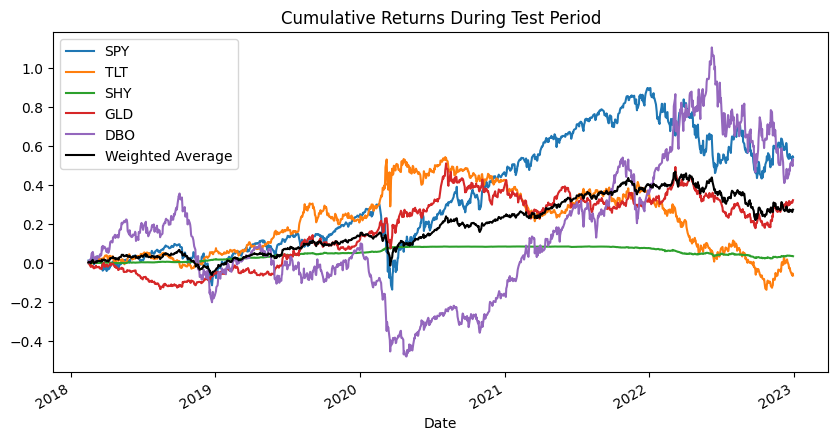

In [369]:
plt.figure(figsize=(10, 5))
for ticker in tickers:
  test_df_cum[ticker].plot()
bh_ret.plot(color='black')
plt.legend(tickers + ['Weighted Average'])
plt.title("Cumulative Returns During Test Period")
plt.show()

### Long Only

In [267]:
print(predictions_df.shape, test_df_cum.shape, test_df.shape)

(1203, 5) (1228, 5) (1258, 5)


In [273]:
predictions_df.iloc[0].sort_values(ascending=False)

DBO    0.089906
GLD    0.037172
SPY    0.026252
SHY    0.000723
TLT   -0.020606
Name: 2018-02-15 00:00:00, dtype: float32

In [290]:
res = predictions_df.iloc[0].sort_values(ascending=False)[:2]
print(res)

DBO    0.089906
GLD    0.037172
Name: 2018-02-15 00:00:00, dtype: float32


In [291]:
res.index.tolist()

['DBO', 'GLD']

In [398]:
cum_rets = []
sel_num = 1 ## pick top 1
step = 25 ## rebalance every 25 days
etfs = ["TLT", "SHY", "GLD", "DBO"]  ## discard SPY because it doesn't train well.

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO'] 0.06582767624963926
2018-03-23 00:00:00 ['DBO'] 0.06630340640740862
2018-04-30 00:00:00 ['GLD'] -0.024940217158708644
2018-06-05 00:00:00 ['TLT'] 0.023412507912811797
2018-07-11 00:00:00 ['DBO'] -0.0375398900185695
2018-08-15 00:00:00 ['DBO'] 0.07385885806593806
2018-09-20 00:00:00 ['DBO'] -0.04327662078788663
2018-10-25 00:00:00 ['GLD'] -0.007886214379046796
2018-11-30 00:00:00 ['GLD'] 0.05002592899943137
2019-01-09 00:00:00 ['DBO'] 0.08378680646803316
2019-02-14 00:00:00 ['GLD'] 0.002512746629588447
2019-03-22 00:00:00 ['TLT'] 0.009213843984816839
2019-04-29 00:00:00 ['DBO'] -0.13914650118247385
2019-06-04 00:00:00 ['GLD'] 0.05307329036252173
2019-07-10 00:00:00 ['DBO'] -0.02564099984699242
2019-08-14 00:00:00 ['DBO'] 0.005060711607270285
2019-09-19 00:00:00 ['GLD'] -0.0012792831069675659
2019-10-24 00:00:00 ['GLD'] -0.025048063068648263
2019-11-29 00:00:00 ['DBO'] 0.08564868693974059
2020-01-07 00:00:00 ['TLT'] 0.04344242984357427
2020-02-12 00:00:00 ['GL

To check the code validility, draw the backtest with DBO for the first 50 days since the top pick is DBO twice. Indeed they overlaps.

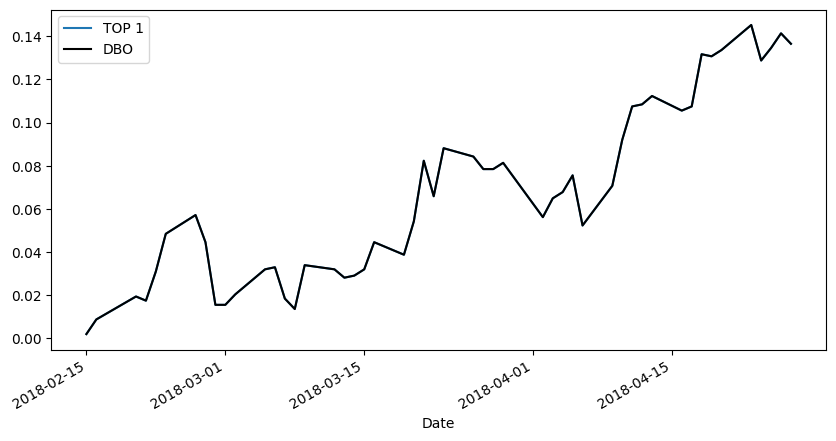

In [382]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.iloc[:50].index, cum_rets[:50])
test_df_cum.iloc[:50].DBO.plot(color='black')
plt.legend(['TOP 1', 'DBO'])
plt.show()

In [ ]:
## 2020-04-24 00:00:00 ['DBO'] 0.19485299780476417
## 2020-06-01 00:00:00 ['DBO'] 0.1076922756280021
## 2020-07-07 00:00:00 ['GLD'] 0.13197999007515615

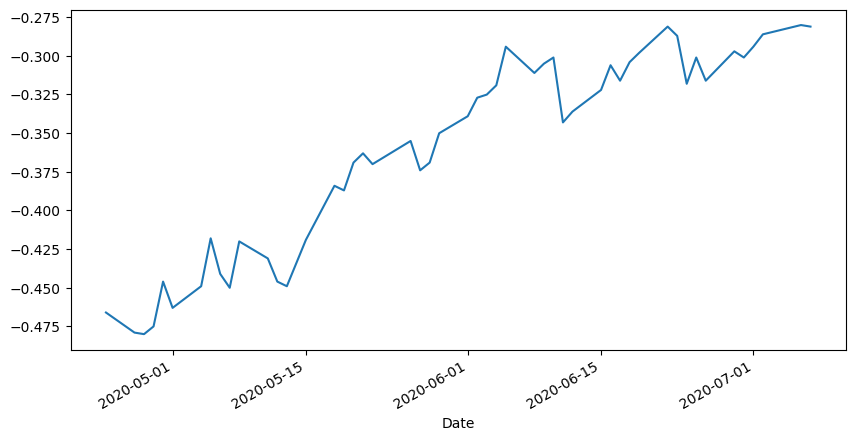

In [393]:
plt.figure(figsize=(10, 5))
test_df_cum[(test_df_cum.index >= '2020-04-24')&(test_df_cum.index <= '2020-07-07')]['DBO'].plot()
plt.show()

Now we draw the backtest result of only longing on the top pick.

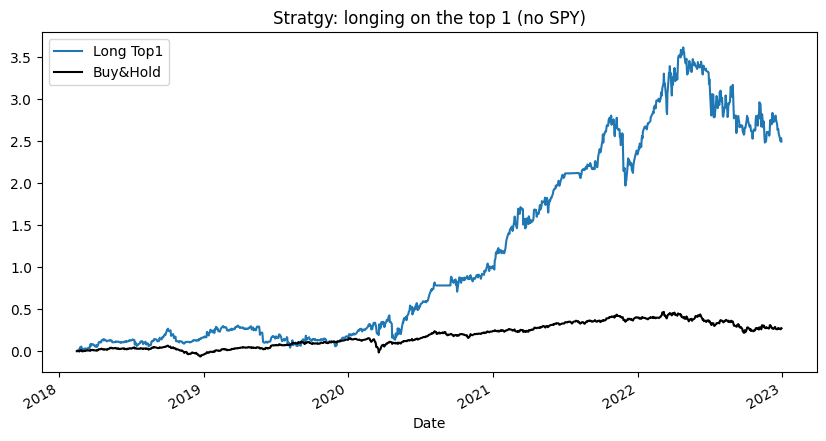

In [399]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top1', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 1 (no SPY)')
plt.show()

If we put SPY back into consideration:

In [483]:
cum_rets = []
sel_num = 1 ## pick top 1
step = 25 ## rebalance every 25 days
etfs = tickers

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO'] 0.06582767624963926
2018-03-23 00:00:00 ['DBO'] 0.06630340640740862
2018-04-30 00:00:00 ['GLD'] -0.024940217158708644
2018-06-05 00:00:00 ['TLT'] 0.023412507912811797
2018-07-11 00:00:00 ['DBO'] -0.0375398900185695
2018-08-15 00:00:00 ['DBO'] 0.07385885806593806
2018-09-20 00:00:00 ['DBO'] -0.04327662078788663
2018-10-25 00:00:00 ['SPY'] 0.0326400301697789
2018-11-30 00:00:00 ['GLD'] 0.05002592899943137
2019-01-09 00:00:00 ['DBO'] 0.08378680646803316
2019-02-14 00:00:00 ['GLD'] 0.002512746629588447
2019-03-22 00:00:00 ['TLT'] 0.009213843984816839
2019-04-29 00:00:00 ['DBO'] -0.13914650118247385
2019-06-04 00:00:00 ['SPY'] 0.08764812387581244
2019-07-10 00:00:00 ['DBO'] -0.02564099984699242
2019-08-14 00:00:00 ['DBO'] 0.005060711607270285
2019-09-19 00:00:00 ['GLD'] -0.0012792831069675659
2019-10-24 00:00:00 ['GLD'] -0.025048063068648263
2019-11-29 00:00:00 ['DBO'] 0.08564868693974059
2020-01-07 00:00:00 ['TLT'] 0.04344242984357427
2020-02-12 00:00:00 ['GLD']

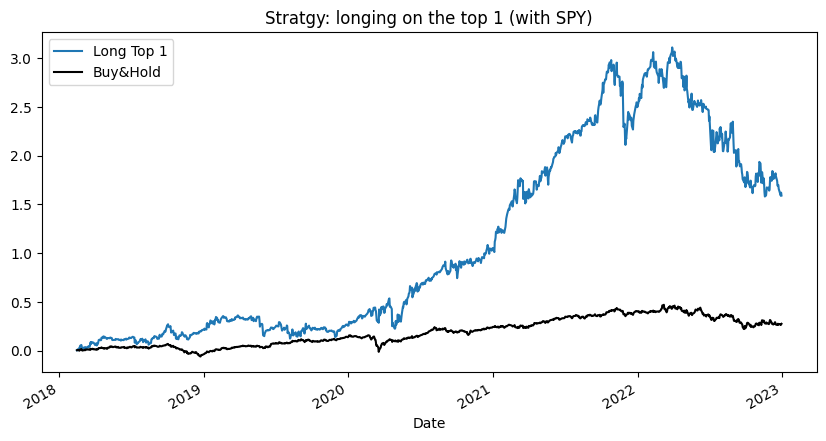

In [484]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top 1', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 1 (with SPY)')
plt.show()

If we pick top 2 ETFs:

In [485]:
cum_rets = []
sel_num = 2 ## pick top 2
step = 25 ## rebalance every 25 days
etfs = ["TLT", "SHY", "GLD", "DBO"]  ## discard SPY because it doesn't train well.

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO', 'GLD'] 0.02414056960118094
2018-03-23 00:00:00 ['DBO', 'TLT'] 0.028512318204572118
2018-04-30 00:00:00 ['GLD', 'DBO'] -0.01374780705363765
2018-06-05 00:00:00 ['TLT', 'SHY'] 0.012547170930454099
2018-07-11 00:00:00 ['DBO', 'TLT'] -0.025089832858560257
2018-08-15 00:00:00 ['DBO', 'TLT'] 0.02333158647604683
2018-09-20 00:00:00 ['DBO', 'GLD'] -0.009432451262663788
2018-10-25 00:00:00 ['GLD', 'TLT'] -0.0022053295625955593
2018-11-30 00:00:00 ['GLD', 'TLT'] 0.05591118341529766
2019-01-09 00:00:00 ['DBO', 'GLD'] 0.049463566921036595
2019-02-14 00:00:00 ['GLD', 'TLT'] 0.009966904482299643
2019-03-22 00:00:00 ['TLT', 'DBO'] 0.016964226389913684
2019-04-29 00:00:00 ['DBO', 'TLT'] -0.03249886542078473
2019-06-04 00:00:00 ['GLD', 'TLT'] 0.027971402593629957
2019-07-10 00:00:00 ['DBO', 'SHY'] -0.00949874786180993
2019-08-14 00:00:00 ['DBO', 'TLT'] -0.0066399244870365415
2019-09-19 00:00:00 ['GLD', 'TLT'] -0.0002667639134279476
2019-10-24 00:00:00 ['GLD', 'TLT'] -0.00719

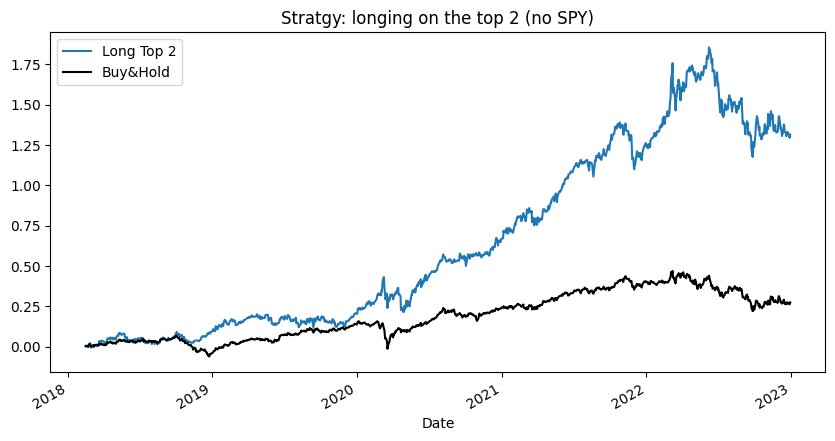

In [486]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top 2', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 2 (no SPY)')
plt.show()

# Step 3 Multi-head LSTM for ETFs

## Model

Based on results in Step 2, we are able to train models using only a 30-day window of 1-day returns. Therefore, for this task, we just need to stack these five time series together and train an LSTM model with five outputs at the same time. The other layers will be kept the same.

In [405]:
def create_LSTM_multihead(window_size, n_features, n_heads, SEED=42):
  K.clear_session()
  tf.random.set_seed(SEED)

  units_lstm = 50
  n_dropout = 0.2
  act_fun = "relu"

  model = Sequential()
  model.add(
      LSTM(
          units=units_lstm,
          return_sequences=True,
          activation="tanh",
          input_shape=(window_size, n_features),
      )
  )

  model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))

  model.add(Dense(units=20, activation=act_fun))

  model.add(Dense(units=10, activation=act_fun))

  model.add(Dense(n_heads))

  return model

In [408]:
model = create_LSTM_multihead(window_size=30, n_features=5, n_heads=5)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 20)                1020      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 32685 (127.68 KB)
Trainable params: 32685 (127.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [413]:
X_train_stack = pd.concat([eval("X_train_" + ticker) for ticker in tickers], axis=1)
X_train_stack.columns = ["Ret_" + ticker for ticker in tickers]

In [414]:
X_train_stack.head()

Ret_SPY   Ret_TLT   Ret_SHY   Ret_GLD   Ret_DBO
Date                                                        
2008-01-03 -0.000483 -0.001378  0.001579  0.008367  0.000838
2008-01-04 -0.024506  0.000213  0.001456 -0.005142 -0.010327
2008-01-07 -0.000849  0.004349 -0.000606 -0.004229 -0.024253
2008-01-08 -0.016148 -0.001162  0.001453  0.023711  0.006069
2008-01-09  0.010510  0.001903 -0.000483 -0.002650 -0.008618

In [416]:
y_train_stack = pd.concat([eval("y_train_" + ticker) for ticker in tickers], axis=1)
y_train_stack.columns = ["Ret25_" + ticker for ticker in tickers]
y_train_stack.head()

Ret25_SPY  Ret25_TLT  Ret25_SHY  Ret25_GLD  Ret25_DBO
Date                                                             
2008-01-03  -0.081389  -0.002379   0.017485   0.063457  -0.064750
2008-01-04  -0.053499   0.001559   0.016369   0.072830  -0.027355
2008-01-07  -0.043912  -0.008713   0.017350   0.053793  -0.021098
2008-01-08  -0.018285  -0.018065   0.016238   0.030652  -0.019247
2008-01-09  -0.037045  -0.034333   0.016001   0.036511   0.011011

In [417]:
X_test_stack = pd.concat([eval("X_test_" + ticker) for ticker in tickers], axis=1)
X_test_stack.columns = ["Ret_" + ticker for ticker in tickers]

In [418]:
y_test_stack = pd.concat([eval("y_test_" + ticker) for ticker in tickers], axis=1)
y_test_stack.columns = ["Ret25_" + ticker for ticker in tickers]

In [422]:
y_train_stack.shape

(2742, 5)

In [421]:
len(y_test_stack)


1233

In [427]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test('stack', window_size, verbose=True, output_scale=False)

window size:  30
Shape of dataset (2742, 5) (2742, 5) (1233, 5) (1233, 5)
Shape of training data (2712, 30, 5) (2712, 5)
Shape of test data (1203, 30, 5) (1233, 5)


In [445]:
mean_ret

Ret25_SPY    0.009252
Ret25_TLT    0.006086
Ret25_SHY    0.001149
Ret25_GLD    0.004054
Ret25_DBO   -0.006420
dtype: float32

### 100 Epochs

In [436]:
np.mean(y_train, axis=0)

array([ 0.09586077,  0.0625907 ,  0.01043094,  0.03434048, -0.07704013],
      dtype=float32)

In [450]:
tse = mean_squared_error(y_train, [np.mean(y_train, axis=0) for _ in range(y_train.shape[0])])
print(tse, tse * 0.6)

0.0033812702 0.0020287621300667524


In [428]:
model = create_LSTM_multihead(window_size=30, n_features=5, n_heads=5)
model.compile(optimizer='adam',loss='mean_squared_error')
stack_predictions_test = model.predict(X_test)
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 6s 24ms/step - loss: 0.0033
Epoch 2/100
85/85 [==============================] - 2s 24ms/step - loss: 0.0032
Epoch 3/100
85/85 [==============================] - 3s 33ms/step - loss: 0.0031
Epoch 4/100
85/85 [==============================] - 2s 27ms/step - loss: 0.0030
Epoch 5/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0029
Epoch 6/100
85/85 [==============================] - 2s 24ms/step - loss: 0.0029
Epoch 7/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0028
Epoch 8/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0026
Epoch 9/100
85/85 [==============================] - 3s 36ms/step - loss: 0.0025
Epoch 10/100
85/85 [==============================] - 2s 24ms/step - loss: 0.0024
Epoch 11/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0024
Epoch 12/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0023
Epoch 13/100
85/85 [=====

In [443]:
stack_predictions_train = model.predict(X_train)
stack_predictions_test = model.predict(X_test)

38/38 [==============================] - 1s 33ms/step


In [429]:
model.save('model_stack_epoch_100.h5')

0.00043719672 0.8292117188263057 0.8679941002949852


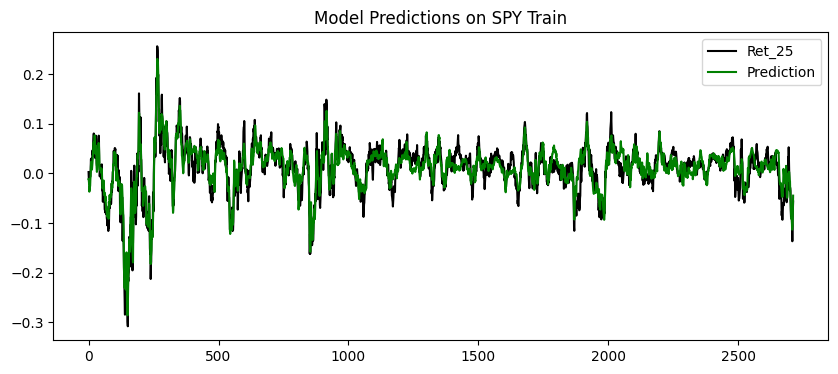

0.00069014664 0.6524308500293245 0.7429941002949852


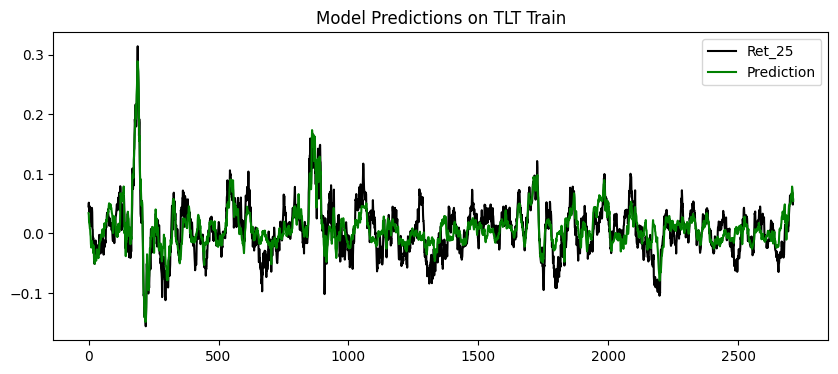

6.9798944e-06 0.33187799408550467 0.668141592920354


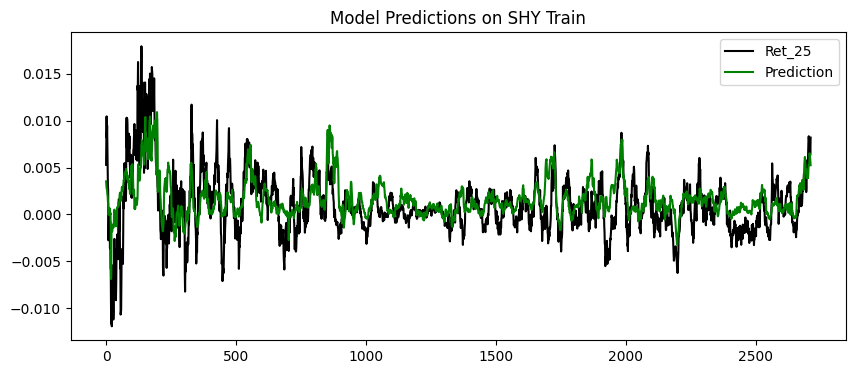

0.00033703083 0.884120616960633 0.8838495575221239


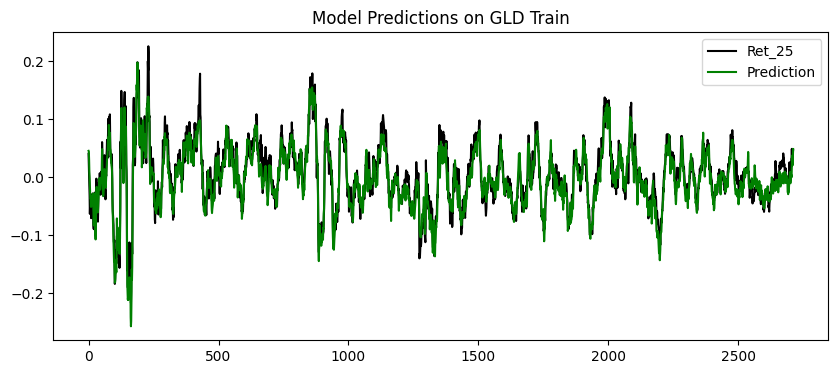

0.00036486494 0.961365930994389 0.9332595870206489


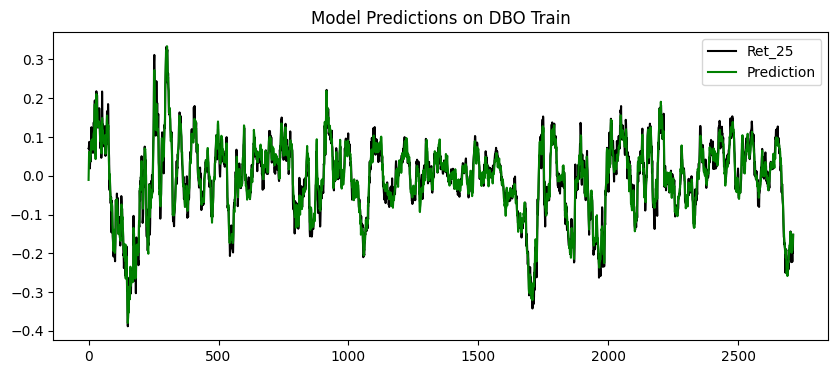

In [447]:
for i in range(5):
  predictions = stack_predictions_train[:,i]
  label = y_train[:,i]
  mse = mean_squared_error(label, predictions)
  r2 = R2_campbell(label, predictions, mean_ret[i])
  acc = cal_sign_accuracy(label, predictions)
  print(mse, r2, acc)
  plt.figure(figsize=(10,4))
  plt.plot(label, color = 'black', label = 'Ret_25')
  plt.plot(predictions, color = 'green', label = 'Prediction')
  plt.legend()
  plt.title("Model Predictions on {} Train".format(tickers[i]))
  plt.show()

0.0044109696 -0.2266809821136575 0.685785536159601


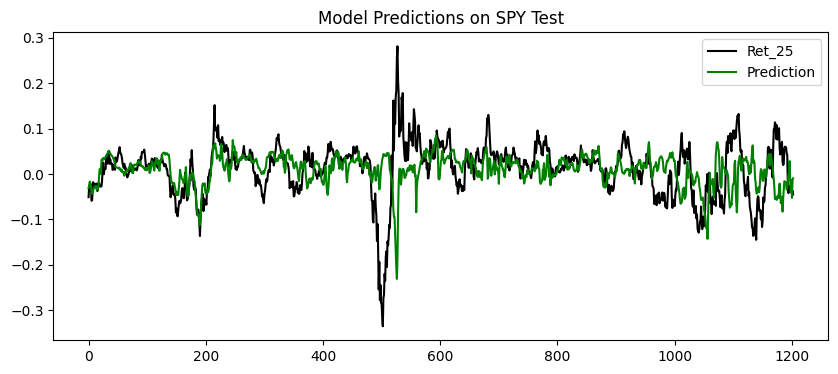

0.002591439 -0.12161528718780779 0.5320033250207814


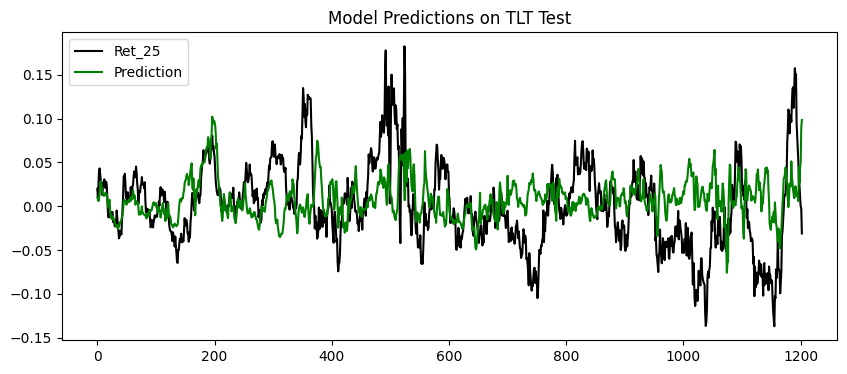

2.8464896e-05 -0.03554837131939603 0.6259351620947631


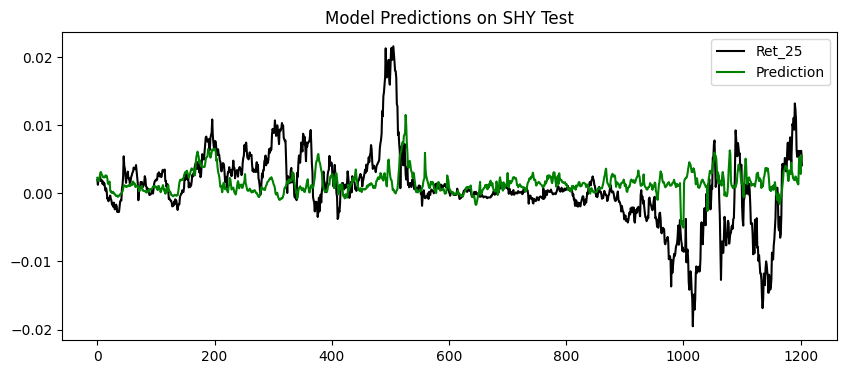

0.0031608776 -0.8317747721638049 0.600997506234414


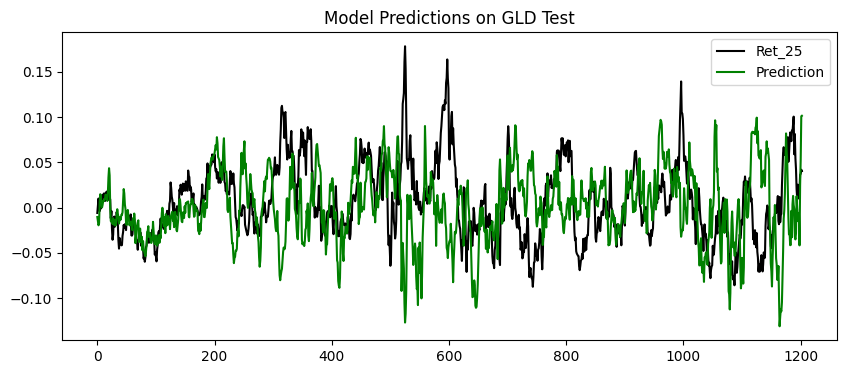

0.012280626 -0.03919872092234078 0.5827098919368247


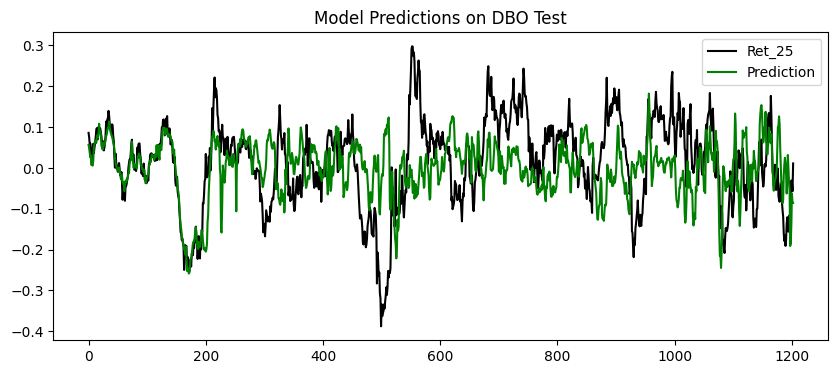

In [449]:
for i in range(5):
  predictions = stack_predictions_test[:,i]
  label = y_test[window_size:,i]
  mse = mean_squared_error(label, predictions)
  r2 = R2_campbell(label, predictions, mean_ret[i])
  acc = cal_sign_accuracy(label, predictions)
  print(mse, r2, acc)
  plt.figure(figsize=(10,4))
  plt.plot(label, color = 'black', label = 'Ret_25')
  plt.plot(predictions, color = 'green', label = 'Prediction')
  plt.legend()
  plt.title("Model Predictions on {} Test".format(tickers[i]))
  plt.show()

### 20 Epochs

In [451]:
model = create_LSTM_multihead(window_size=30, n_features=5, n_heads=5)
model.compile(optimizer='adam',loss='mean_squared_error')
stack_predictions_test = model.predict(X_test)
model.fit(X_train,y_train,epochs=20,batch_size=32)

38/38 [==============================] - 1s 8ms/step
Epoch 1/20
85/85 [==============================] - 7s 36ms/step - loss: 0.0033
Epoch 2/20
85/85 [==============================] - 2s 26ms/step - loss: 0.0031
Epoch 3/20
85/85 [==============================] - 2s 25ms/step - loss: 0.0031
Epoch 4/20
85/85 [==============================] - 3s 38ms/step - loss: 0.0030
Epoch 5/20
85/85 [==============================] - 5s 59ms/step - loss: 0.0030
Epoch 6/20
85/85 [==============================] - 4s 47ms/step - loss: 0.0029
Epoch 7/20
85/85 [==============================] - 4s 50ms/step - loss: 0.0029
Epoch 8/20
85/85 [==============================] - 4s 49ms/step - loss: 0.0027
Epoch 9/20
85/85 [==============================] - 4s 41ms/step - loss: 0.0027
Epoch 10/20
85/85 [==============================] - 2s 25ms/step - loss: 0.0026
Epoch 11/20
85/85 [==============================] - 2s 24ms/step - loss: 0.0025
Epoch 12/20
85/85 [==============================] - 2s 25ms/step

In [452]:
model.save('model_stack_epoch_20.h5')

In [464]:
stack_predictions_train = model.predict(X_train)
stack_predictions_test = model.predict(X_test)

38/38 [==============================] - 1s 13ms/step


0.0012553664 0.5095986565314112 0.734882005899705


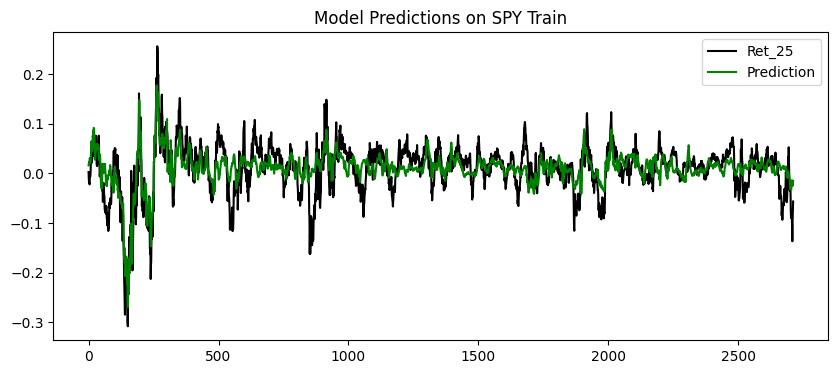

0.0013654522 0.3123358626706856 0.5851769911504425


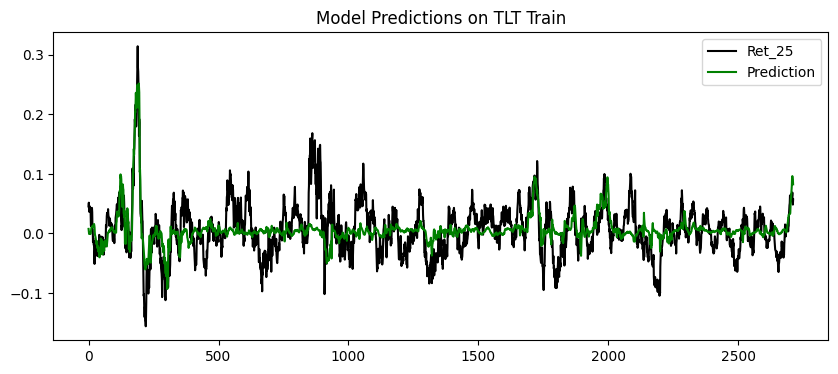

2.3514285e-05 -1.2508094333925013 0.525811209439528


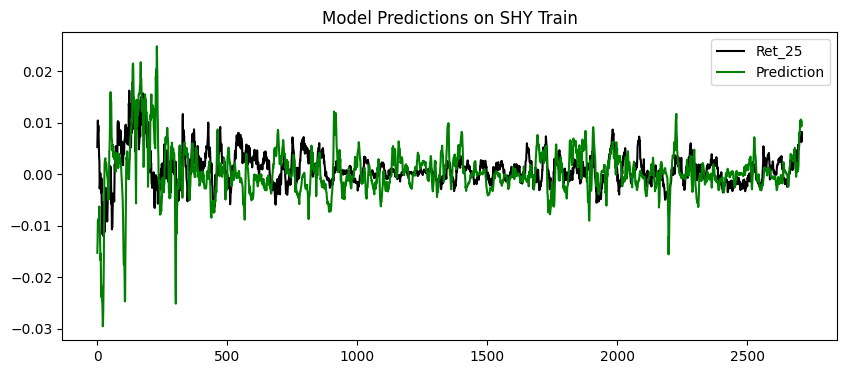

0.002158767 0.2577634490430817 0.5814896755162242


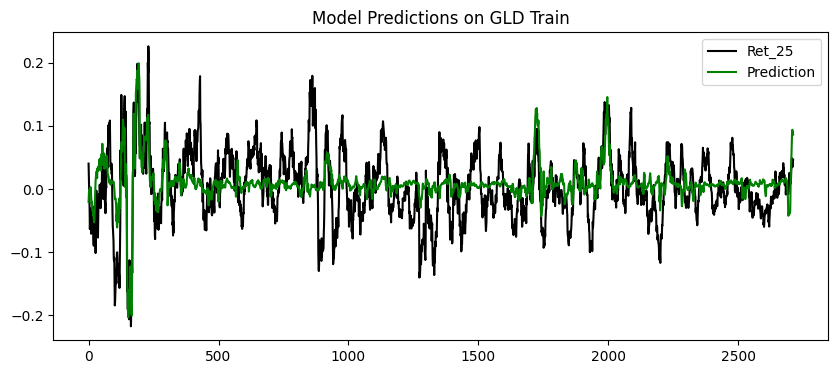

0.004402851 0.5337999117487696 0.6976401179941003


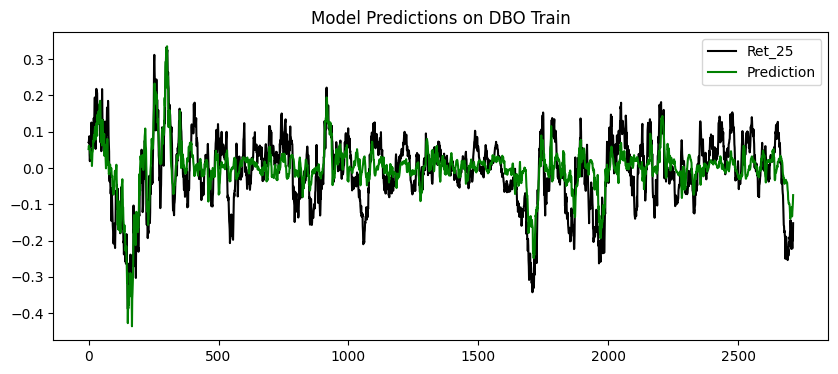

In [465]:
for i in range(5):
  predictions = stack_predictions_train[:,i]
  label = y_train[:,i]
  mse = mean_squared_error(label, predictions)
  r2 = R2_campbell(label, predictions, mean_ret[i])
  acc = cal_sign_accuracy(label, predictions)
  print(mse, r2, acc)
  plt.figure(figsize=(10,4))
  plt.plot(label, color = 'black', label = 'Ret_25')
  plt.plot(predictions, color = 'green', label = 'Prediction')
  plt.legend()
  plt.title("Model Predictions on {} Train".format(tickers[i]))
  plt.show()

0.003858235 -0.07296666890634307 0.6492103075644223


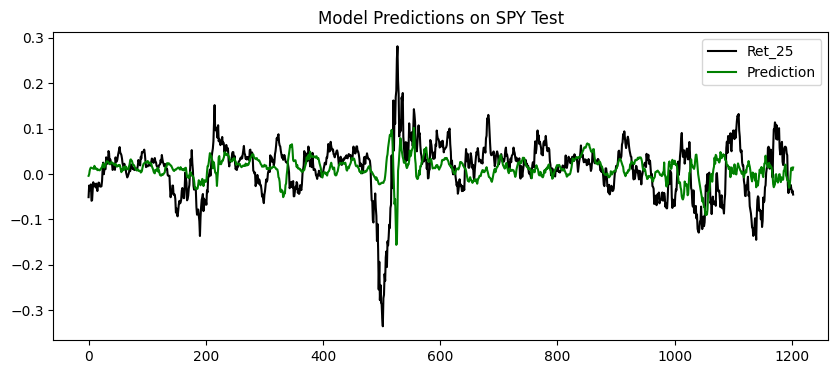

0.00232174 -0.004885165315255735 0.4837905236907731


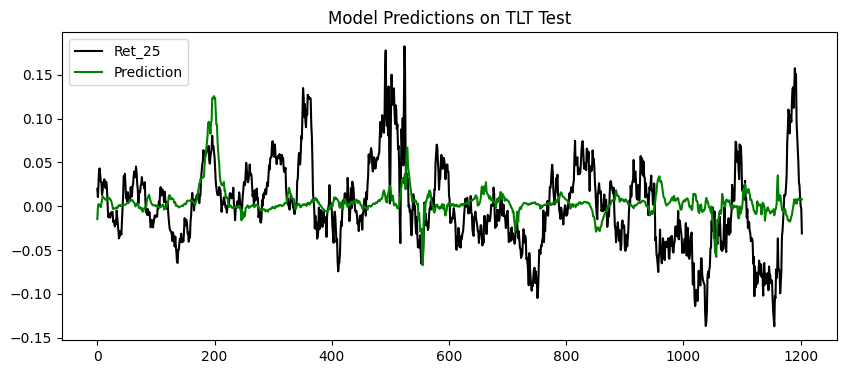

3.9398354e-05 -0.433305856392173 0.4945968412302577


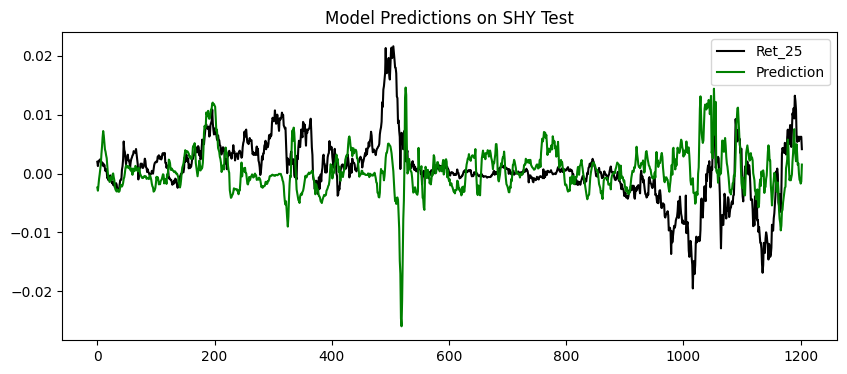

0.0021285203 -0.23350857742799858 0.4829592684954281


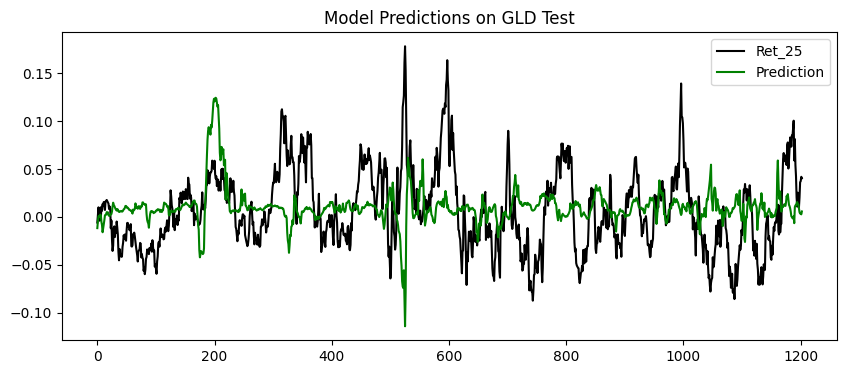

0.012229794 -0.034897231715967925 0.457190357439734


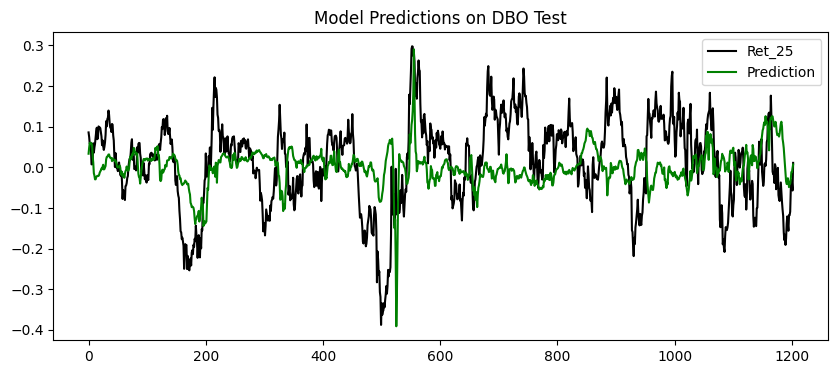

In [466]:
for i in range(5):
  predictions = stack_predictions_test[:,i]
  label = y_test[window_size:,i]
  mse = mean_squared_error(label, predictions)
  r2 = R2_campbell(label, predictions, mean_ret[i])
  acc = cal_sign_accuracy(label, predictions)
  print(mse, r2, acc)
  plt.figure(figsize=(10,4))
  plt.plot(label, color = 'black', label = 'Ret_25')
  plt.plot(predictions, color = 'green', label = 'Prediction')
  plt.legend()
  plt.title("Model Predictions on {} Test".format(tickers[i]))
  plt.show()

### 50 Epochs

In [455]:
model = create_LSTM_multihead(window_size=30, n_features=5, n_heads=5)
model.compile(optimizer='adam',loss='mean_squared_error')
stack_predictions_test = model.predict(X_test)
model.fit(X_train,y_train,epochs=50,batch_size=32)

38/38 [==============================] - 2s 12ms/step
Epoch 1/50
85/85 [==============================] - 11s 50ms/step - loss: 0.0033
Epoch 2/50
85/85 [==============================] - 5s 62ms/step - loss: 0.0032
Epoch 3/50
85/85 [==============================] - 3s 40ms/step - loss: 0.0031
Epoch 4/50
85/85 [==============================] - 3s 35ms/step - loss: 0.0030
Epoch 5/50
85/85 [==============================] - 4s 44ms/step - loss: 0.0029
Epoch 6/50
85/85 [==============================] - 3s 33ms/step - loss: 0.0028
Epoch 7/50
85/85 [==============================] - 3s 35ms/step - loss: 0.0027
Epoch 8/50
85/85 [==============================] - 3s 36ms/step - loss: 0.0025
Epoch 9/50
85/85 [==============================] - 4s 43ms/step - loss: 0.0025
Epoch 10/50
85/85 [==============================] - 5s 53ms/step - loss: 0.0024
Epoch 11/50
85/85 [==============================] - 4s 46ms/step - loss: 0.0023
Epoch 12/50
85/85 [==============================] - 2s 29ms/st

In [456]:
model.save('model_stack_epoch_50.h5')

In [459]:
stack_predictions_train = model.predict(X_train)
stack_predictions_test = model.predict(X_test)

38/38 [==============================] - 1s 13ms/step


0.0010073076 0.6065013269776793 0.7728613569321534


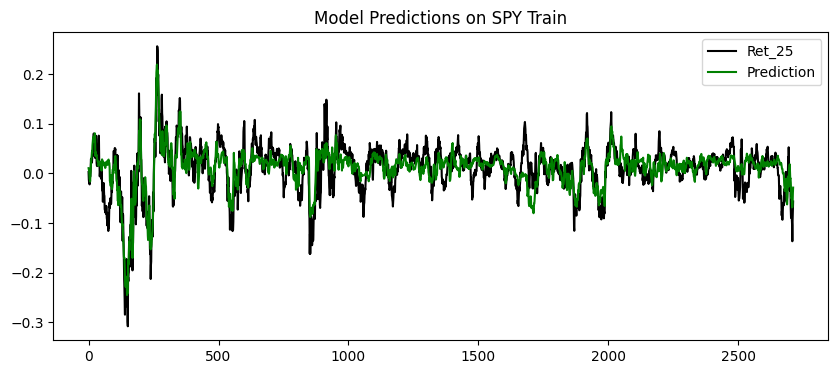

0.00090279465 0.5453378238469745 0.6913716814159292


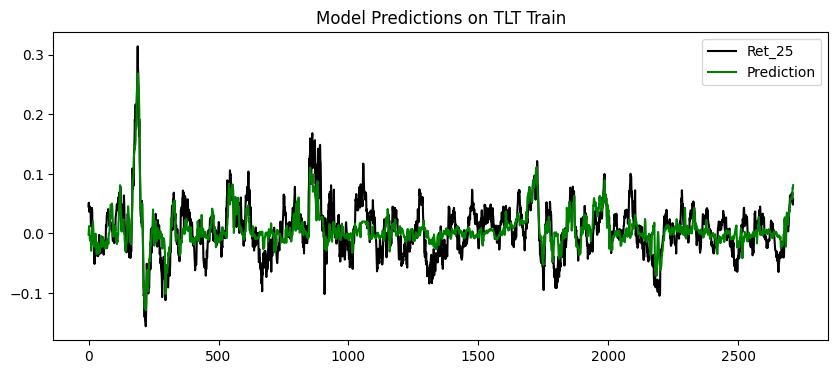

7.2746952e-06 0.3036593721030414 0.6242625368731564


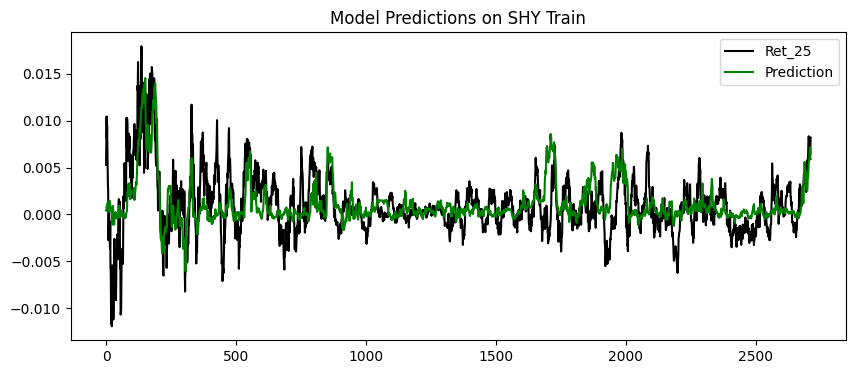

0.0013449775 0.5375640566846405 0.7127581120943953


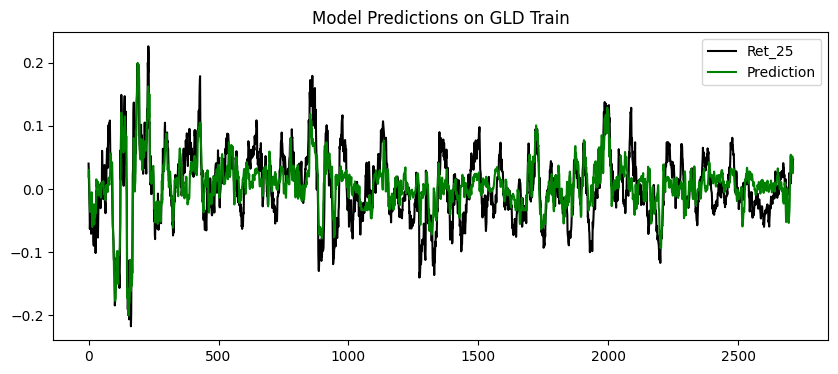

0.0011789862 0.8751619291643459 0.870575221238938


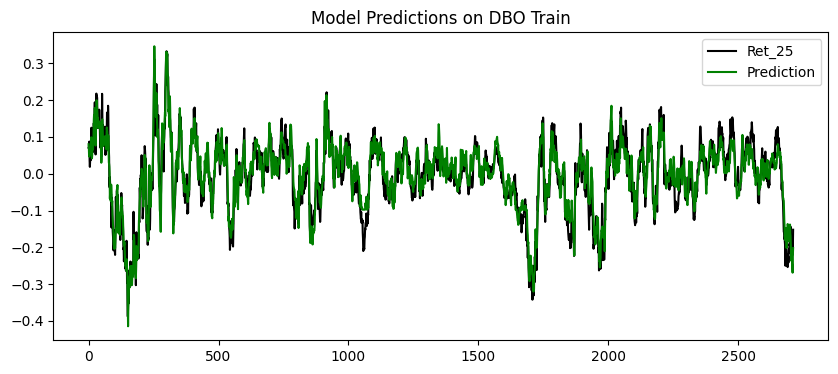

In [460]:
for i in range(5):
  predictions = stack_predictions_train[:,i]
  label = y_train[:,i]
  mse = mean_squared_error(label, predictions)
  r2 = R2_campbell(label, predictions, mean_ret[i])
  acc = cal_sign_accuracy(label, predictions)
  print(mse, r2, acc)
  plt.figure(figsize=(10,4))
  plt.plot(label, color = 'black', label = 'Ret_25')
  plt.plot(predictions, color = 'green', label = 'Prediction')
  plt.legend()
  plt.title("Model Predictions on {} Train".format(tickers[i]))
  plt.show()

0.0040633264 -0.13000226108344126 0.6367414796342478


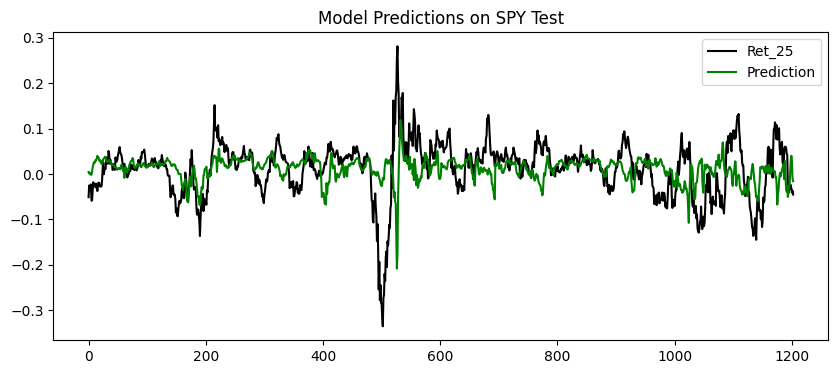

0.0029244383 -0.26574247710867427 0.4829592684954281


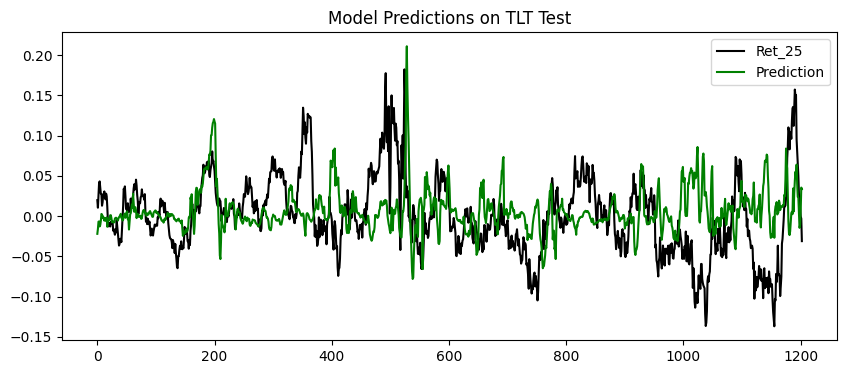

3.0106032e-05 -0.09525250443844202 0.5785536159600998


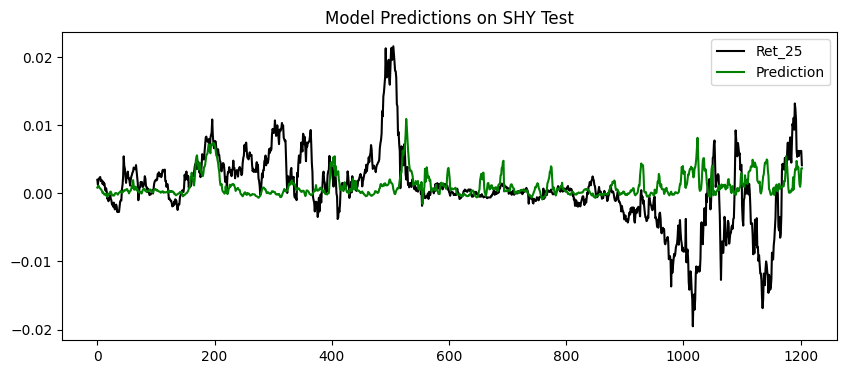

0.0026826186 -0.554616706946313 0.4937655860349127


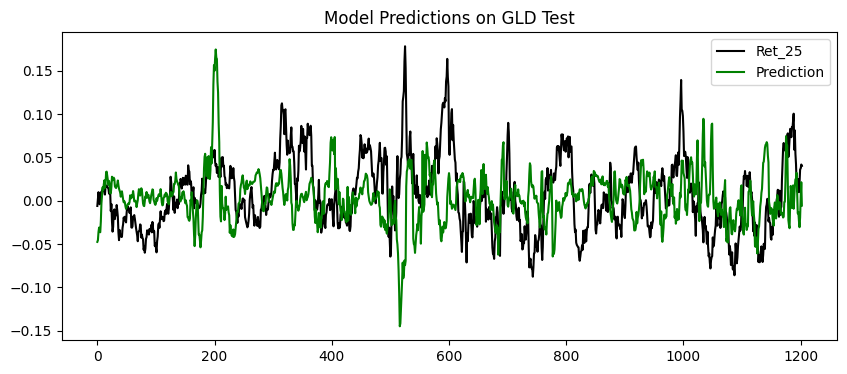

0.014037246 -0.1878456615248938 0.542809642560266


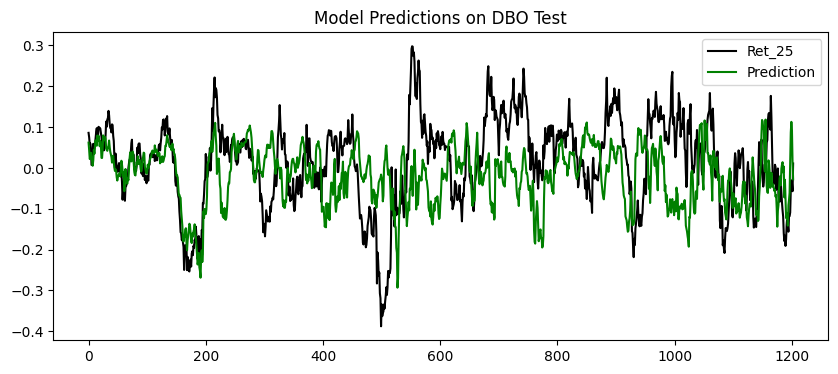

In [461]:
for i in range(5):
  predictions = stack_predictions_test[:,i]
  label = y_test[window_size:,i]
  mse = mean_squared_error(label, predictions)
  r2 = R2_campbell(label, predictions, mean_ret[i])
  acc = cal_sign_accuracy(label, predictions)
  print(mse, r2, acc)
  plt.figure(figsize=(10,4))
  plt.plot(label, color = 'black', label = 'Ret_25')
  plt.plot(predictions, color = 'green', label = 'Prediction')
  plt.legend()
  plt.title("Model Predictions on {} Test".format(tickers[i]))
  plt.show()

## Trading Strategy

### Predictions

Based on sign agreement, we choose to use the model trained 100 epochs for this section.

In [488]:
model = load_model('model_stack_epoch_100.h5')

In [489]:
X_train, y_train, X_test, y_test, scaler_output, mean_ret = create_train_test('stack', window_size, verbose=True, output_scale=False)
predictions_stack = model.predict(X_test)

window size:  30
Shape of dataset (2742, 5) (2742, 5) (1233, 5) (1233, 5)
Shape of training data (2712, 30, 5) (2712, 5)
Shape of test data (1203, 30, 5) (1233, 5)
38/38 [==============================] - 1s 8ms/step


In [490]:
predictions_df = pd.DataFrame(predictions_stack)
predictions_df.columns = tickers
predictions_df.index = y_test_stack[window_size:].index
predictions_df.head()

SPY       TLT       SHY       GLD       DBO
Date                                                        
2018-02-15 -0.030989  0.009961  0.002295 -0.010488  0.056443
2018-02-16 -0.024628  0.007792  0.002059 -0.015167  0.048433
2018-02-20 -0.016877  0.005891  0.001794 -0.019665  0.035896
2018-02-21 -0.019485  0.008950  0.001938 -0.017347  0.025705
2018-02-22 -0.025738  0.016247  0.002391  0.005369  0.031028

### Long Top 1

In [474]:
cum_rets = []
sel_num = 1 ## pick top 1
step = 25 ## rebalance every 25 days
etfs = tickers

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO'] 0.06582767624963926
2018-03-23 00:00:00 ['DBO'] 0.06630340640740862
2018-04-30 00:00:00 ['SPY'] 0.03128782560278931
2018-06-05 00:00:00 ['DBO'] 0.06917168421580877
2018-07-11 00:00:00 ['SPY'] 0.017927285526759373
2018-08-15 00:00:00 ['DBO'] 0.07385885806593806
2018-09-20 00:00:00 ['TLT'] -0.013497712010600904
2018-10-25 00:00:00 ['TLT'] 0.0034755552538556778
2018-11-30 00:00:00 ['TLT'] 0.06179643783116373
2019-01-09 00:00:00 ['SPY'] 0.07095838474287386
2019-02-14 00:00:00 ['GLD'] 0.002512746629588447
2019-03-22 00:00:00 ['DBO'] 0.024714608795010307
2019-04-29 00:00:00 ['TLT'] 0.07414877034090428
2019-06-04 00:00:00 ['SPY'] 0.08764812387581244
2019-07-10 00:00:00 ['SPY'] -0.015613140509763368
2019-08-14 00:00:00 ['TLT'] -0.018340560581343368
2019-09-19 00:00:00 ['GLD'] -0.0012792831069675659
2019-10-24 00:00:00 ['DBO'] 0.04149789712601648
2019-11-29 00:00:00 ['DBO'] 0.08564868693974059
2020-01-07 00:00:00 ['SPY'] 0.0359041917562708
2020-02-12 00:00:00 ['GLD']

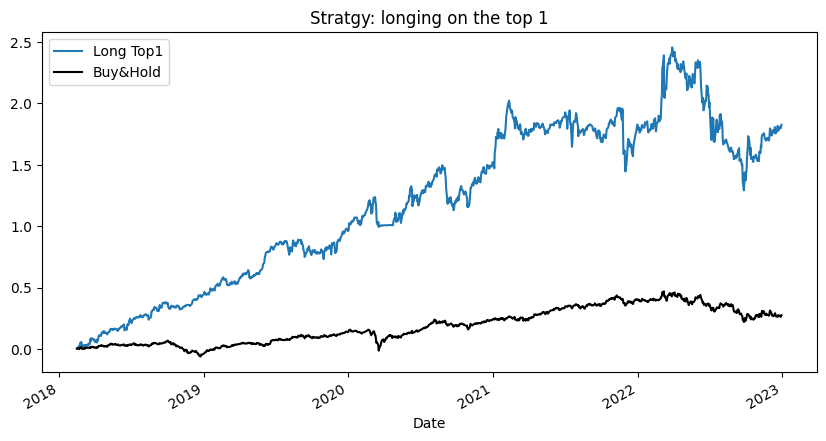

In [475]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top1', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 1')
plt.show()

### Long Top 2

In [476]:
cum_rets = []
sel_num = 2 ## pick top 1
step = 25 ## rebalance every 25 days
etfs = tickers

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO', 'TLT'] 0.04494982242212986
2018-03-23 00:00:00 ['DBO', 'SPY'] 0.03863193656318353
2018-04-30 00:00:00 ['SPY', 'TLT'] 0.02019179724401443
2018-06-05 00:00:00 ['DBO', 'SPY'] 0.044139123299754335
2018-07-11 00:00:00 ['SPY', 'TLT'] 0.0026437549141040684
2018-08-15 00:00:00 ['DBO', 'SPY'] 0.04982118525772172
2018-09-20 00:00:00 ['TLT', 'SHY'] -0.005380278508476444
2018-10-25 00:00:00 ['TLT', 'SHY'] 0.0032811298408135237
2018-11-30 00:00:00 ['TLT', 'GLD'] 0.05591118341529766
2019-01-09 00:00:00 ['SPY', 'GLD'] 0.043049356058457056
2019-02-14 00:00:00 ['GLD', 'SPY'] 0.02124658058068496
2019-03-22 00:00:00 ['DBO', 'SPY'] 0.02759962739494437
2019-04-29 00:00:00 ['TLT', 'GLD'] 0.05248180784135137
2019-06-04 00:00:00 ['SPY', 'TLT'] 0.0452588193502752
2019-07-10 00:00:00 ['SPY', 'SHY'] -0.00448481819319535
2019-08-14 00:00:00 ['TLT', 'GLD'] -0.012943704167953651
2019-09-19 00:00:00 ['GLD', 'TLT'] -0.0002667639134279476
2019-10-24 00:00:00 ['DBO', 'SPY'] 0.046759240134294

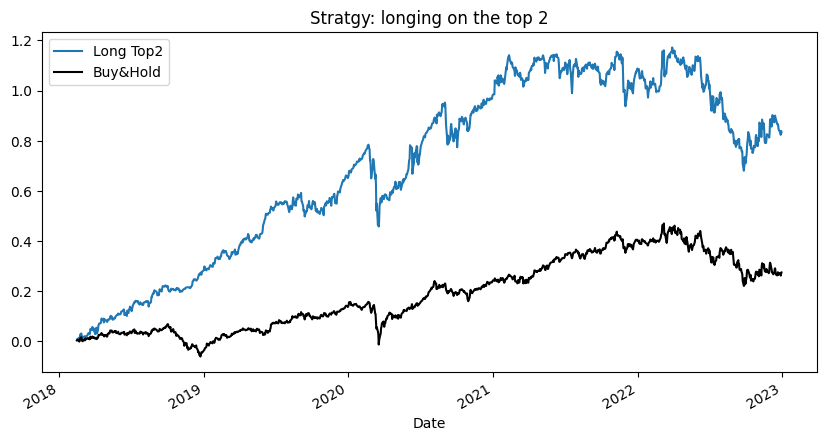

In [477]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top2', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 2')
plt.show()

### Long Top 1 with no SPY

In [478]:
cum_rets = []
sel_num = 1 ## pick top 1
step = 25 ## rebalance every 25 days
etfs = ["TLT", "SHY", "GLD", "DBO"] ## without SPY

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO'] 0.06582767624963926
2018-03-23 00:00:00 ['DBO'] 0.06630340640740862
2018-04-30 00:00:00 ['TLT'] 0.009095768885239774
2018-06-05 00:00:00 ['DBO'] 0.06917168421580877
2018-07-11 00:00:00 ['TLT'] -0.012639775698551126
2018-08-15 00:00:00 ['DBO'] 0.07385885806593806
2018-09-20 00:00:00 ['TLT'] -0.013497712010600904
2018-10-25 00:00:00 ['TLT'] 0.0034755552538556778
2018-11-30 00:00:00 ['TLT'] 0.06179643783116373
2019-01-09 00:00:00 ['GLD'] 0.015140327374040252
2019-02-14 00:00:00 ['GLD'] 0.002512746629588447
2019-03-22 00:00:00 ['DBO'] 0.024714608795010307
2019-04-29 00:00:00 ['TLT'] 0.07414877034090428
2019-06-04 00:00:00 ['TLT'] 0.002869514824738184
2019-07-10 00:00:00 ['SHY'] 0.006643504123372557
2019-08-14 00:00:00 ['TLT'] -0.018340560581343368
2019-09-19 00:00:00 ['GLD'] -0.0012792831069675659
2019-10-24 00:00:00 ['DBO'] 0.04149789712601648
2019-11-29 00:00:00 ['DBO'] 0.08564868693974059
2020-01-07 00:00:00 ['TLT'] 0.04344242984357427
2020-02-12 00:00:00 ['G

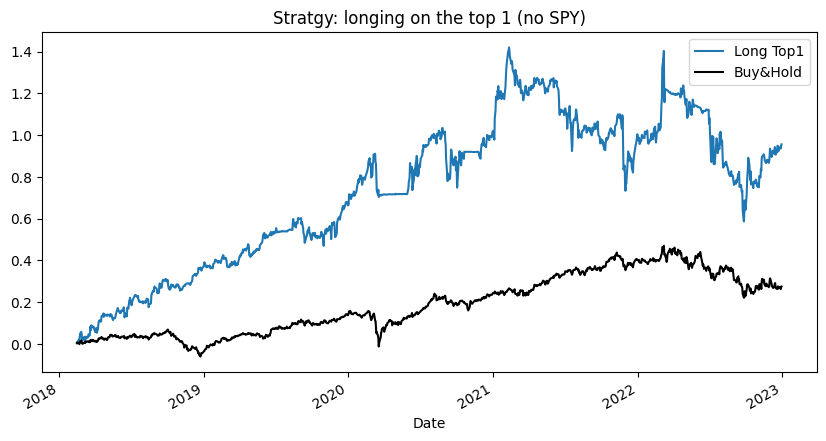

In [479]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top1', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 1 (no SPY)')
plt.show()

### Long Top 2 with no SPY

In [491]:
cum_rets = []
sel_num = 2 ## pick top 1
step = 25 ## rebalance every 25 days
etfs = ["TLT", "SHY", "GLD", "DBO"]

for i in range(0, predictions_df[etfs].shape[0], step):
  pred_rets = predictions_df[etfs].iloc[i]
  pred_dt = pred_rets.name
  tops = pred_rets.sort_values(ascending=False)[:sel_num].index.tolist()
  if i + step < predictions_df.shape[0]:
    df = test_df.iloc[window_size+i : window_size+i+step]
  else:
    df = test_df.iloc[window_size+i :]

  rets = [df[ticker].expanding().apply(lambda x: np.prod(1 + x)) for ticker in tops]
  means = list(np.mean(rets, axis=0))

  print(pred_dt, tops, means[-1] - 1)
  if i != 0:
    last = cum_rets[-1]
    means = [ele * last for ele in means]

  cum_rets += means

cum_rets = [ele-1 for ele in cum_rets]

2018-02-15 00:00:00 ['DBO', 'TLT'] 0.04494982242212986
2018-03-23 00:00:00 ['DBO', 'SHY'] 0.03263542955308241
2018-04-30 00:00:00 ['TLT', 'SHY'] 0.005322288636937067
2018-06-05 00:00:00 ['DBO', 'SHY'] 0.035426759081952586
2018-07-11 00:00:00 ['TLT', 'SHY'] -0.005368559341555557
2018-08-15 00:00:00 ['DBO', 'SHY'] 0.03645298764980609
2018-09-20 00:00:00 ['TLT', 'SHY'] -0.005380278508476444
2018-10-25 00:00:00 ['TLT', 'SHY'] 0.0032811298408135237
2018-11-30 00:00:00 ['TLT', 'GLD'] 0.05591118341529766
2019-01-09 00:00:00 ['GLD', 'TLT'] 0.007338277819223915
2019-02-14 00:00:00 ['GLD', 'DBO'] 0.02936886239354175
2019-03-22 00:00:00 ['DBO', 'SHY'] 0.014468676769380906
2019-04-29 00:00:00 ['TLT', 'GLD'] 0.05248180784135137
2019-06-04 00:00:00 ['TLT', 'GLD'] 0.027971402593629957
2019-07-10 00:00:00 ['SHY', 'TLT'] 0.0418087764969064
2019-08-14 00:00:00 ['TLT', 'GLD'] -0.012943704167953651
2019-09-19 00:00:00 ['GLD', 'TLT'] -0.0002667639134279476
2019-10-24 00:00:00 ['DBO', 'SHY'] 0.0211611450442

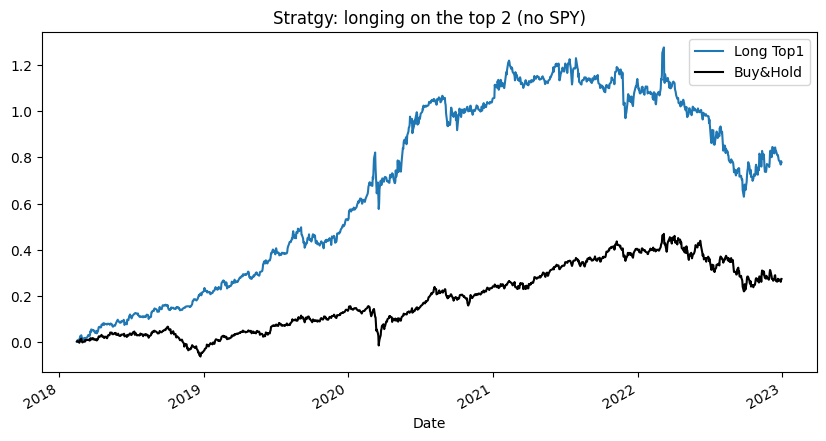

In [492]:
plt.figure(figsize=(10, 5))
plt.plot(test_df_cum.index, cum_rets)
bh_ret.plot(color='black')
plt.legend(['Long Top1', 'Buy&Hold'])
plt.title('Stratgy: longing on the top 2 (no SPY)')
plt.show()